## ToDos:
1. Train-Test-Split
2. EDA
3. Impute missing values
4. BaseLine Model
5. Make Features and Target Stationary
6. Model 

In [360]:
# Import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
sns.set()
plt.style.use('seaborn-talk')


import eda
from function_model import RSME, MAE, plot_model_performance, walk_forward_prediction_ARIMA, \
                            create_season, cv_split, walkforward_baseline, walkforward_naive, walkforward_ARIMA, \
                            walkforward_Prophet_uni, walkforward_Catboost, plot_CV_Catboost

In [2]:
%load_ext autoreload
%autoreload 2

In [359]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

## Read Data

In [3]:
df = pd.read_csv("./data/Aquifer_Petrignano.csv", index_col=0, parse_dates=True, dayfirst=True)
df.index.freq = 'D'

### Rename Columns

In [395]:
print(df.columns)
columns = ['Rf_BU', 'DtG_P24', 'DtG_P25', 'T_BU', 'T_Pe', 'V_Pe', 'H_FCP']
columns_dict = {'Rf_BU' : 'Rainfall - \n Bastia Umbra [mm]', 'DtG_P24' : 'Depth to \n Groundwater \n (P24) [m]', 'DtG_P25' : 'Depth to \n Groundwater \n (P25) [m]', 
                'T_BU' : 'Temperature - \n Bastia Umbra [mm]', 'T_Pe' : 'Temperature - \n Petrignano [mm]', 'V_Pe' : 'Drainage [m3]', 'H_FCP' : 'Hydrometry [m]'}
df.columns = columns

Index(['Rf_BU', 'DtG_P24', 'DtG_P25', 'T_BU', 'T_Pe', 'V_Pe', 'H_FCP'], dtype='object')


In [5]:
df.head(1)

Rf_BU  DtG_P24  DtG_P25  T_BU  T_Pe  V_Pe  H_FCP
Date                                                        
2006-03-14    NaN   -22.48   -22.18   NaN   NaN   NaN    NaN

In [6]:
df.count()

Rf_BU      4199
DtG_P24    5168
DtG_P25    5184
T_BU       4199
T_Pe       4199
V_Pe       5025
H_FCP      4199
dtype: int64

In [7]:
df.isna().sum()

Rf_BU      1024
DtG_P24      55
DtG_P25      39
T_BU       1024
T_Pe       1024
V_Pe        198
H_FCP      1024
dtype: int64

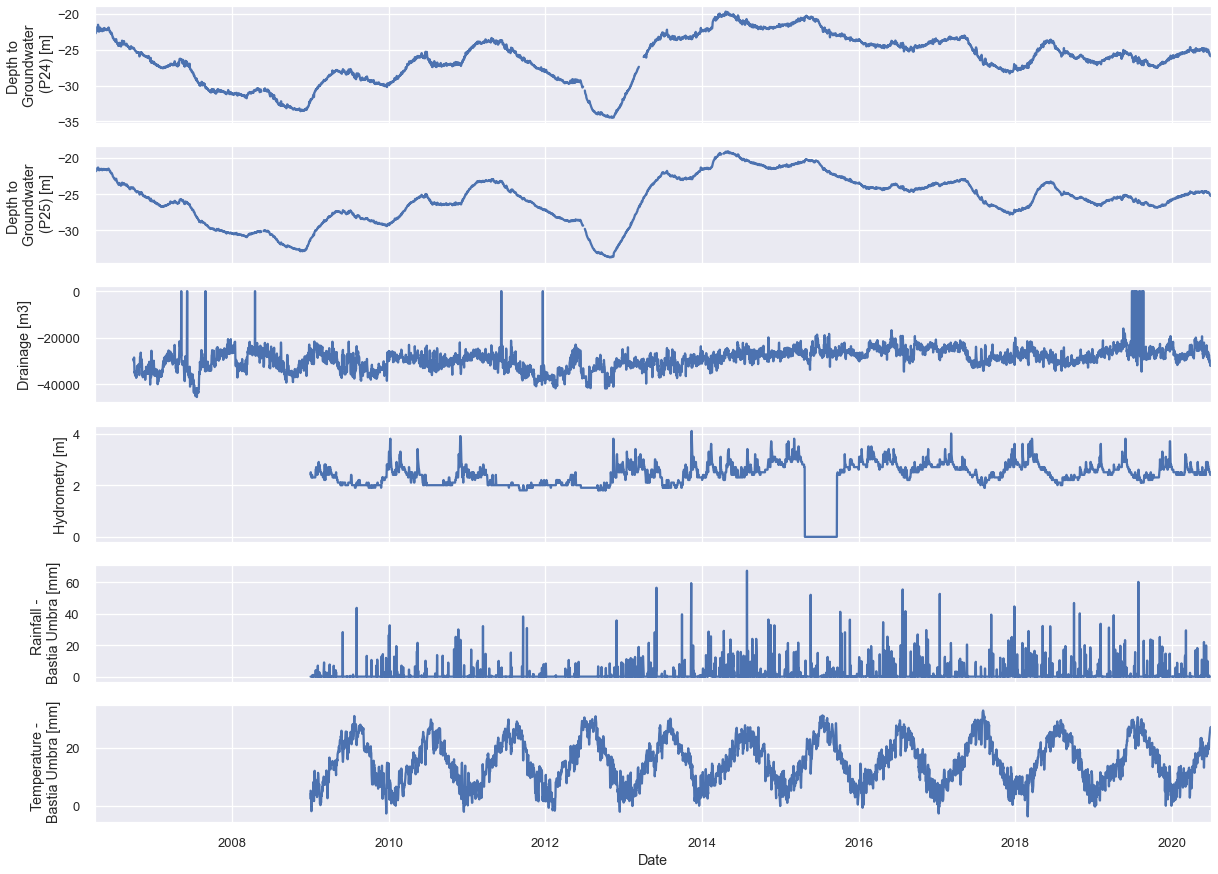

In [410]:
data_plot = eda.plot_time_series(df[['DtG_P24', 'DtG_P25', 'V_Pe', 'H_FCP', 'Rf_BU', 'T_BU']], '2006-04-01', '2020-06-30', (20, 15),  columns_dict)
data_plot.savefig('./graphs/data_overview.jpg', bbox_inches='tight')

### Replace zero values of V_Pe, H_FCP, T_Pe with NaN

In [201]:
df_imputed = df.copy()

In [202]:
df_imputed['T_Pe'] = np.where(((df['T_Pe'] == 0) & (df['T_Pe'].shift(1) == 0)) | (df['T_Pe'].diff(-1) > 10) | ((df['T_Pe'] == 0) & (df['T_Pe'].shift(-1) == 0)), np.nan, df['T_Pe'])
df_imputed['V_Pe'] = np.where(df['V_Pe'] == 0, np.nan, df['V_Pe'])
df_imputed['H_FCP'] = np.where(df['H_FCP'] == 0, np.nan, df['H_FCP'])

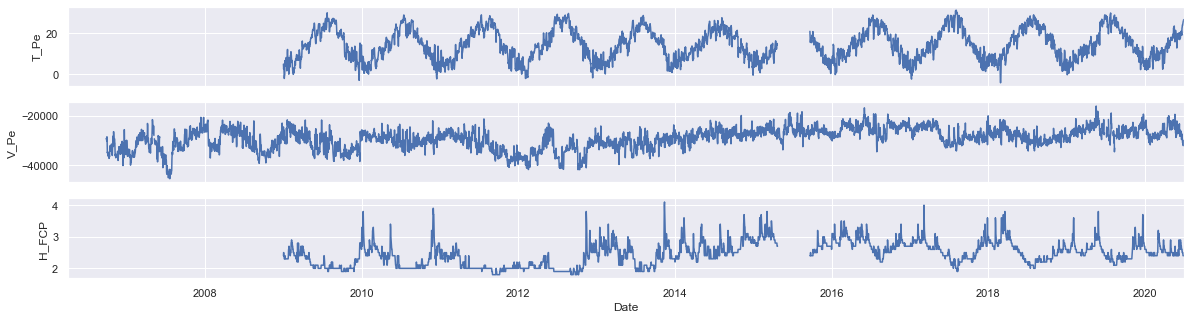

In [203]:
eda.plot_time_series(df_imputed[['T_Pe', 'V_Pe', 'H_FCP']], '2006-04-01', '2020-06-30', (20,5))

### Replace NaN in dataset

#### T_Pe

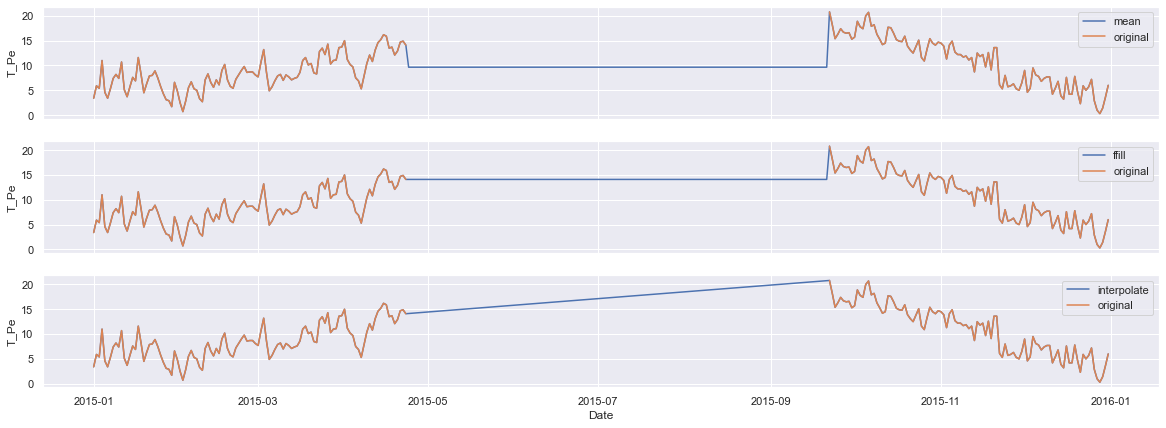

In [13]:
eda.plot_nan_replacement(df_imputed['T_Pe'], '2015', '2015', (20,7)) 

#### V_Pe

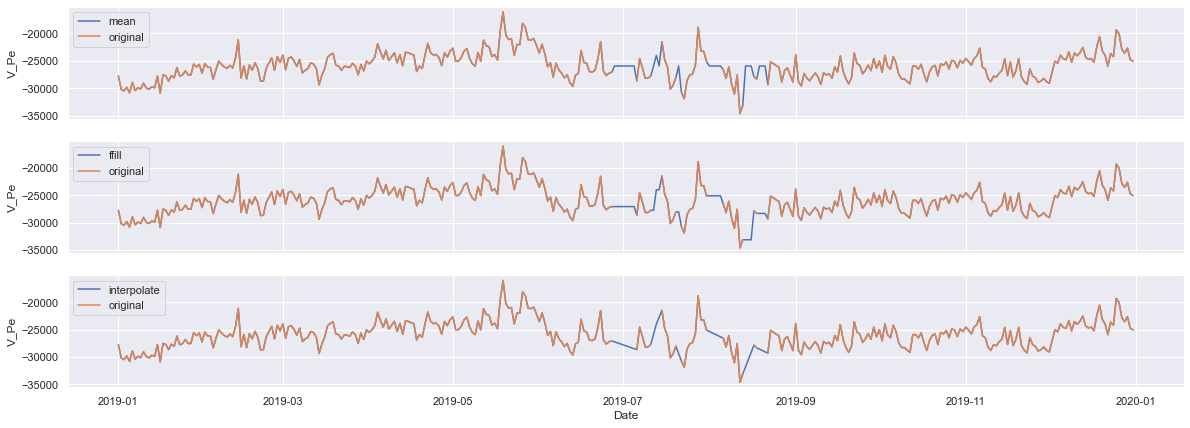

In [14]:
eda.plot_nan_replacement(df_imputed['V_Pe'], '2019', '2019', (20,7)) 

#### H_FCP

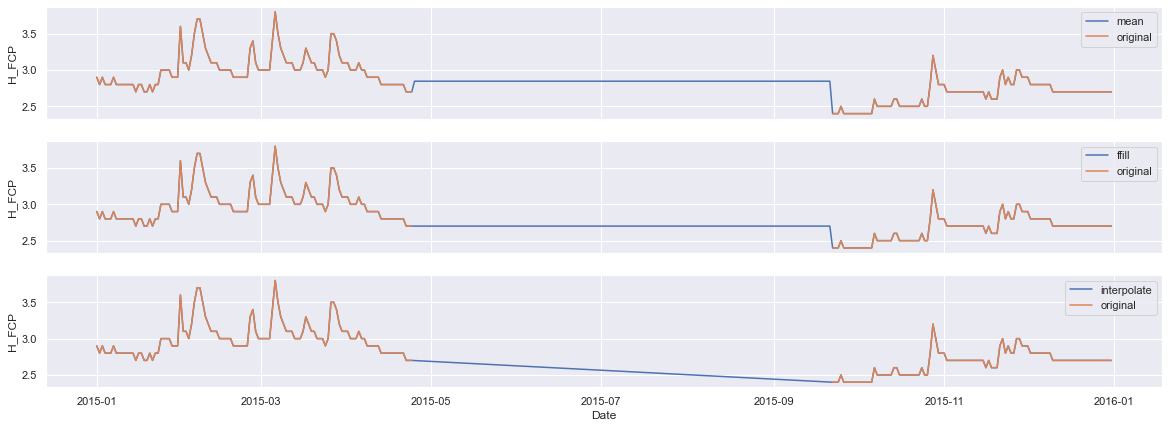

In [15]:
eda.plot_nan_replacement(df_imputed['H_FCP'], '2015', '2015', (20,7))

#### DtG_P24

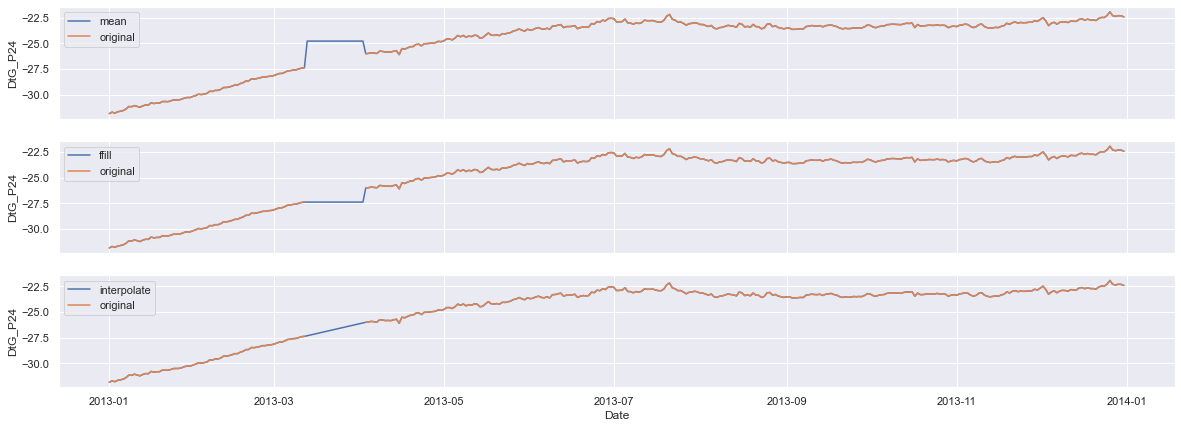

In [16]:
eda.plot_nan_replacement(df_imputed['DtG_P24'], '2013', '2013', (20,7))

### Impute missing values

In [204]:
df_imputed['T_Pe'] = df['T_Pe'].fillna(df['T_BU'])
df_imputed['V_Pe'] = df_imputed['V_Pe'].interpolate()
df_imputed['H_FCP'] = df_imputed['H_FCP'].interpolate()
df_imputed['DtG_P25'] = df_imputed['DtG_P25'].interpolate()
df_imputed['DtG_P24'] = df_imputed['DtG_P24'].interpolate()

## Check for consistent spacing

In [205]:
(df_imputed.index - df_imputed.index.shift(-1)).value_counts()

1 days    5223
Name: Date, dtype: int64

## Downsampling to a weekly interval to reduce noise

In [206]:
col_mean = ['DtG_P25', 'V_Pe', 'H_FCP', 'T_BU']
col_sum = ['Rf_BU']
df_weekly = df_imputed[col_mean].resample('W').mean()
df_weekly['Rf_BU'] = df_imputed[col_sum].resample('W').sum()
df_weekly = df_weekly.loc['2009':]

## EDA

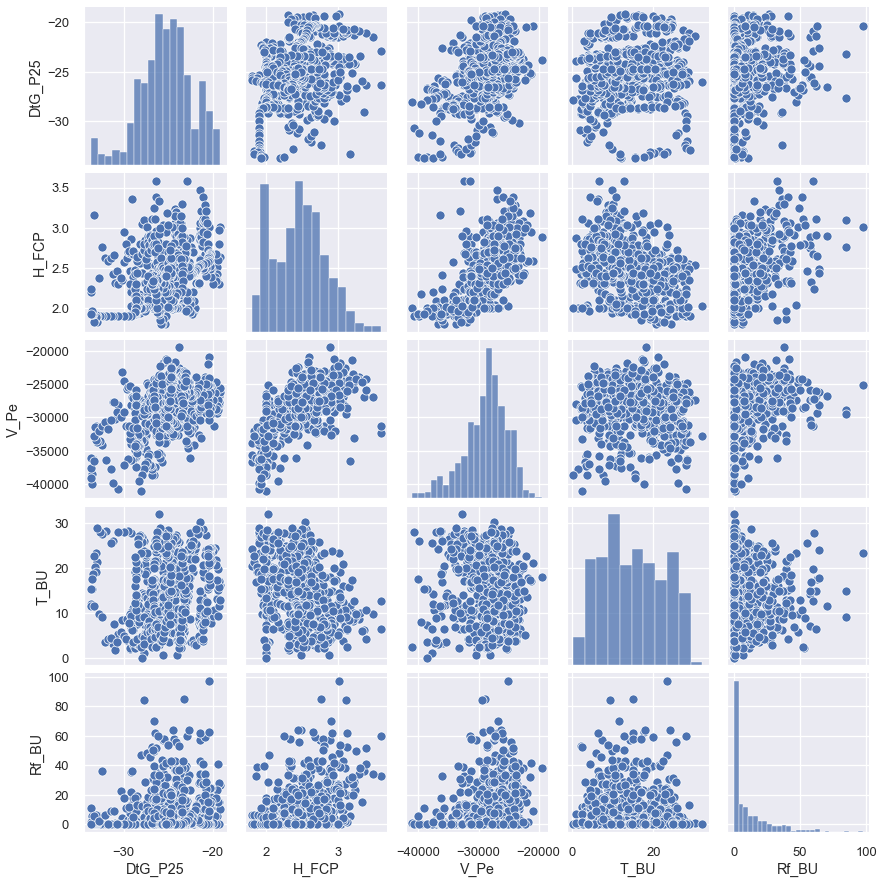

In [372]:
sns.pairplot(df_weekly)

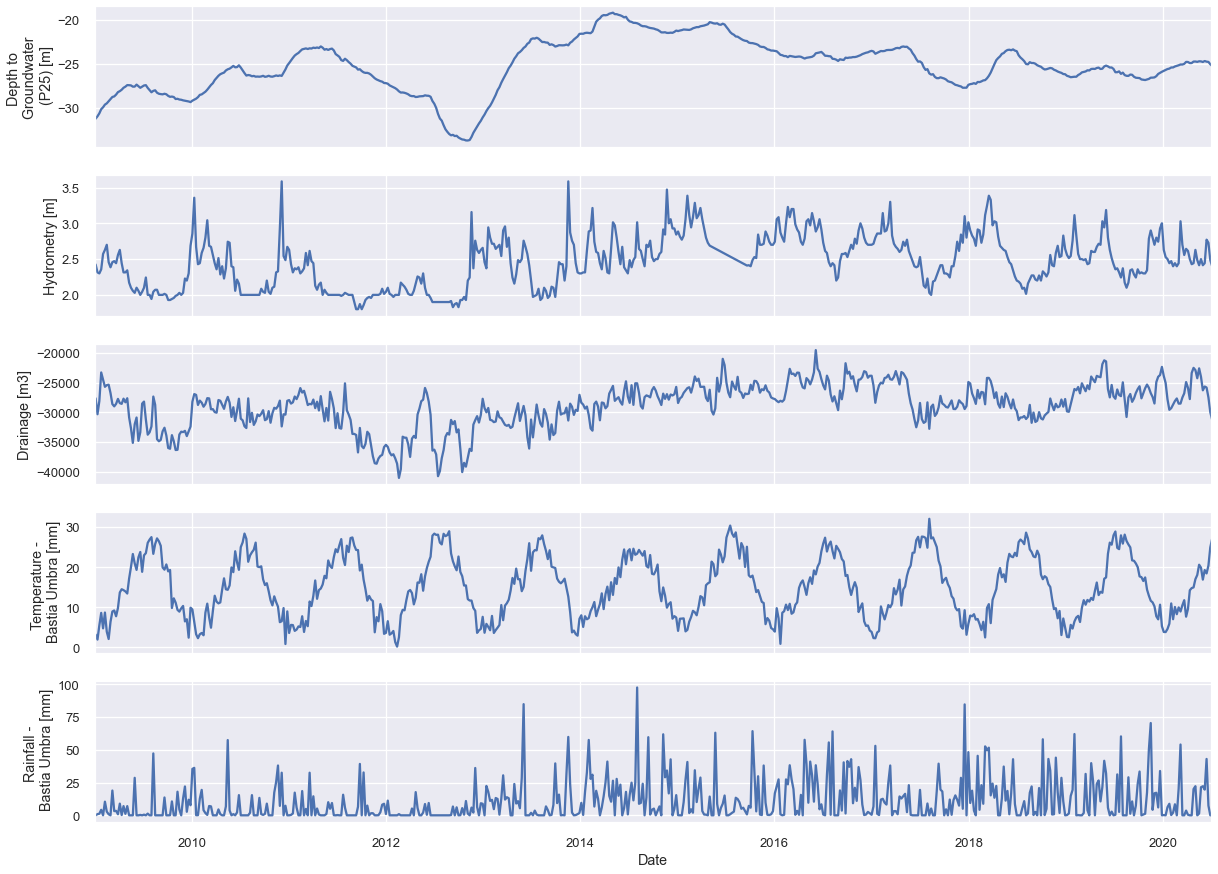

In [411]:
weekly_plot = eda.plot_time_series(df_weekly, '2009-01-01', '2020-06-30', (20,15), columns_dict)
weekly_plot.savefig('./graphs/weekly_data.jpg', bbox_inches='tight')

### Yearly Average

In [323]:
yearly_mean = df_weekly[['DtG_P25', 'H_FCP', 'V_Pe', 'T_BU']].groupby(df_weekly.index.year).mean().round(2)
yearly_sum =  df_weekly[['Rf_BU']].groupby(df_weekly.index.year).sum().round(2)

yearly = yearly_mean.join(yearly_sum)

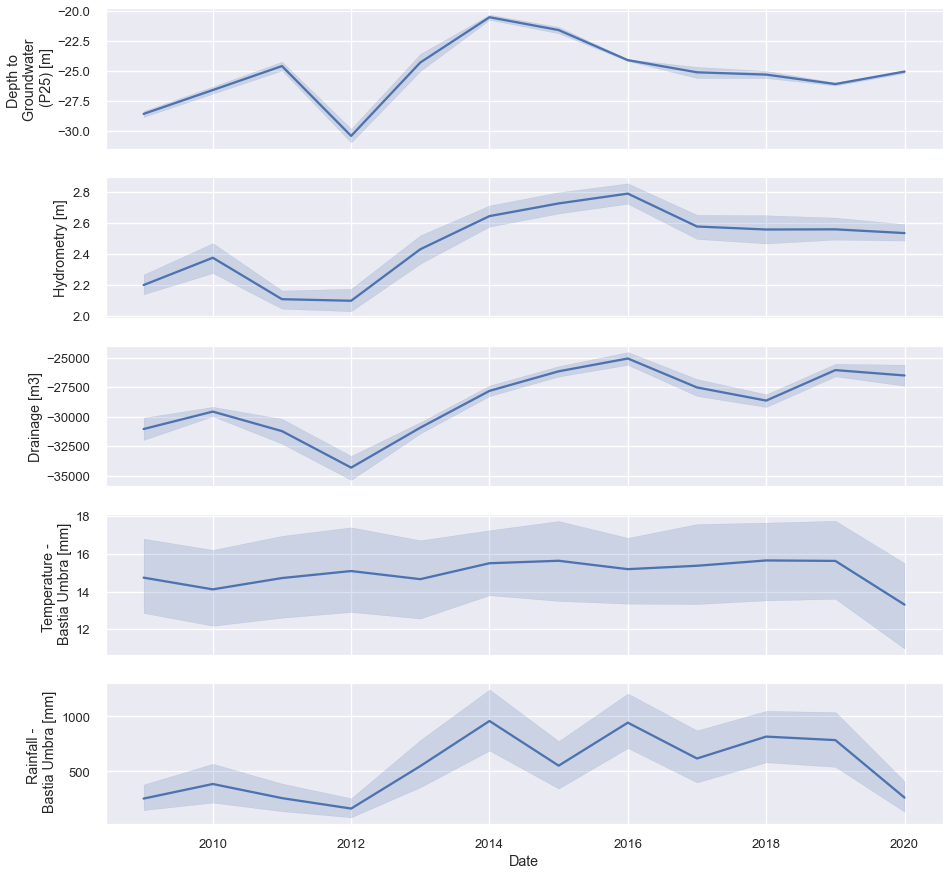

In [414]:
f, ax = plt.subplots(nrows=5, figsize=(15,15), sharex=True)
for i in range(len(yearly.columns)-1):
    column = yearly.columns[i]
    sns.lineplot(x=df_weekly.index.year, y=df_weekly[column], ax=ax[i])
    ax[i].set_ylabel(columns_dict[column])
    
sns.lineplot(x=df_weekly.index.year, y=df_weekly['Rf_BU'], estimator='sum', ax=ax[4])
ax[4].set_ylabel(columns_dict['Rf_BU'])
plt.show()
f.savefig('./graphs/yearly_data.jpg', bbox_inches='tight')

### Monthly Average

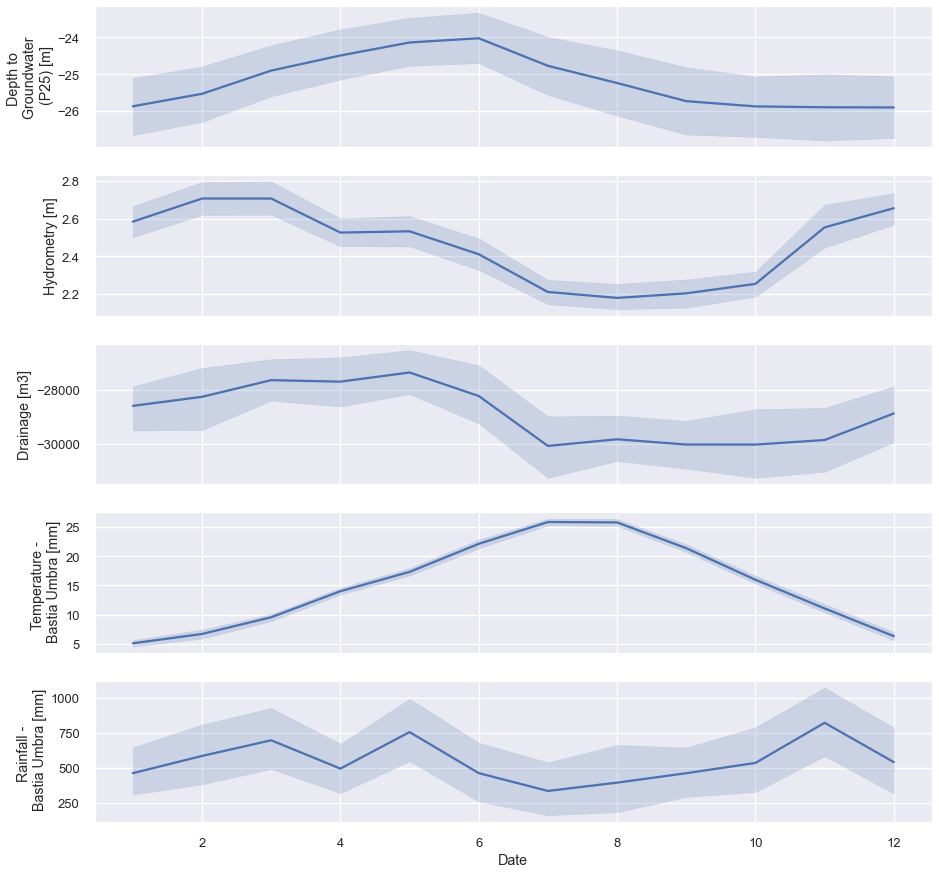

In [1160]:
f, ax = plt.subplots(nrows=5, figsize=(15,15), sharex=True)
for i in range(len(yearly.columns)-1):
    column = yearly.columns[i]
    sns.lineplot(x=df_weekly.index.month, y=df_weekly[column], ax=ax[i])
    ax[i].set_ylabel(columns_dict[column])
    
sns.lineplot(x=df_weekly.index.month, y=df_weekly['Rf_BU'], estimator='sum', ax=ax[4])
ax[4].set_ylabel(columns_dict['Rf_BU'])
plt.show()
f.savefig('./graphs/monthly_data.jpg', bbox_inches='tight')

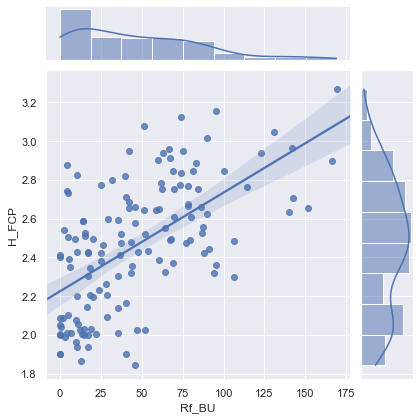

In [341]:
sns.jointplot(x=df_weekly['Rf_BU'].resample('M').sum(), y=df_weekly['H_FCP'].resample('M').mean(), kind="reg", truncate=False)

/Users/marf/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


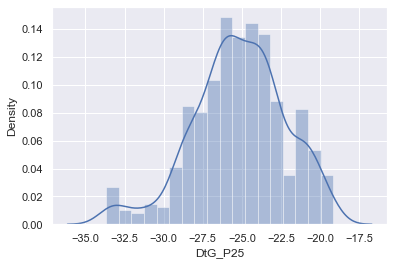

In [344]:
sns.distplot(df_weekly['DtG_P25'])

### Decompose features

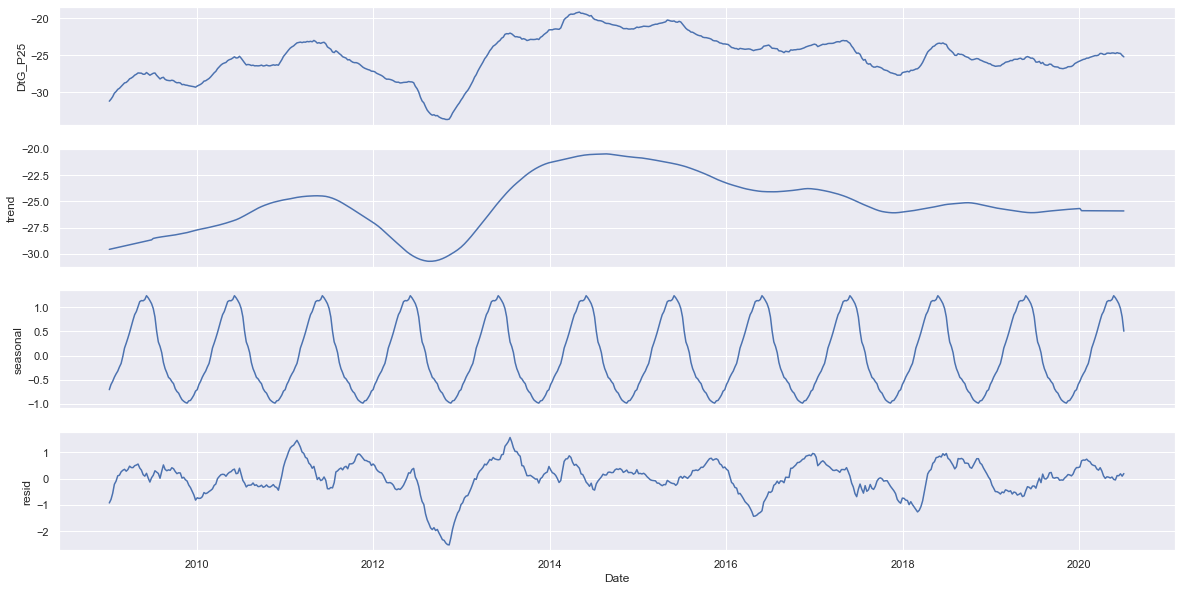

In [208]:
y_decompose = eda.decompose_features(df_weekly['DtG_P25'], 52)

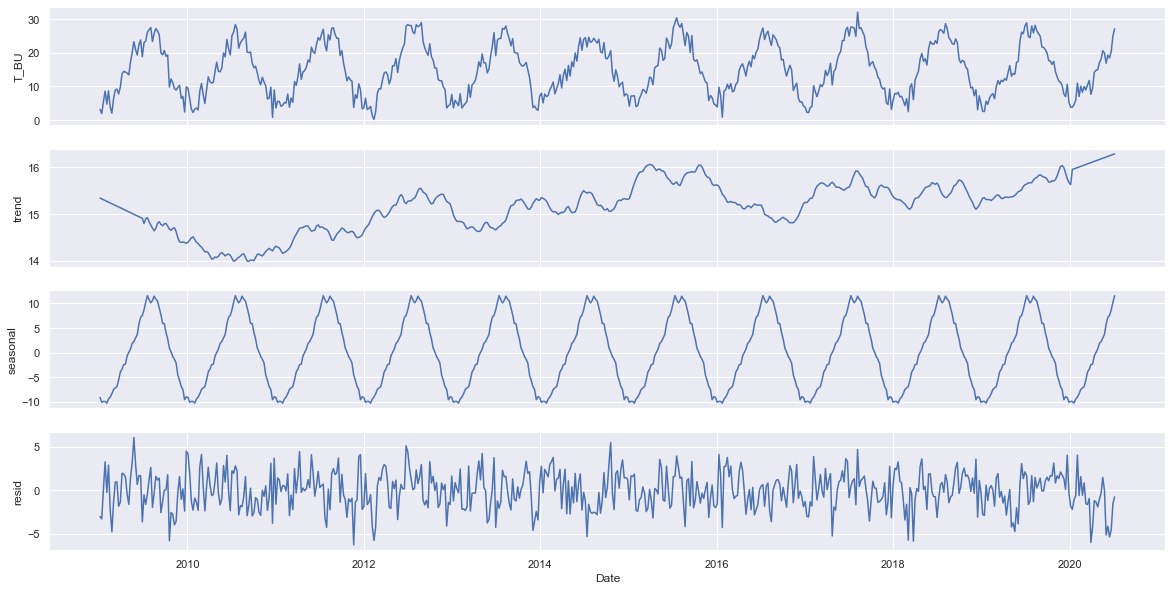

In [209]:
temp_decompose = eda.decompose_features(df_weekly['T_BU'], 52)

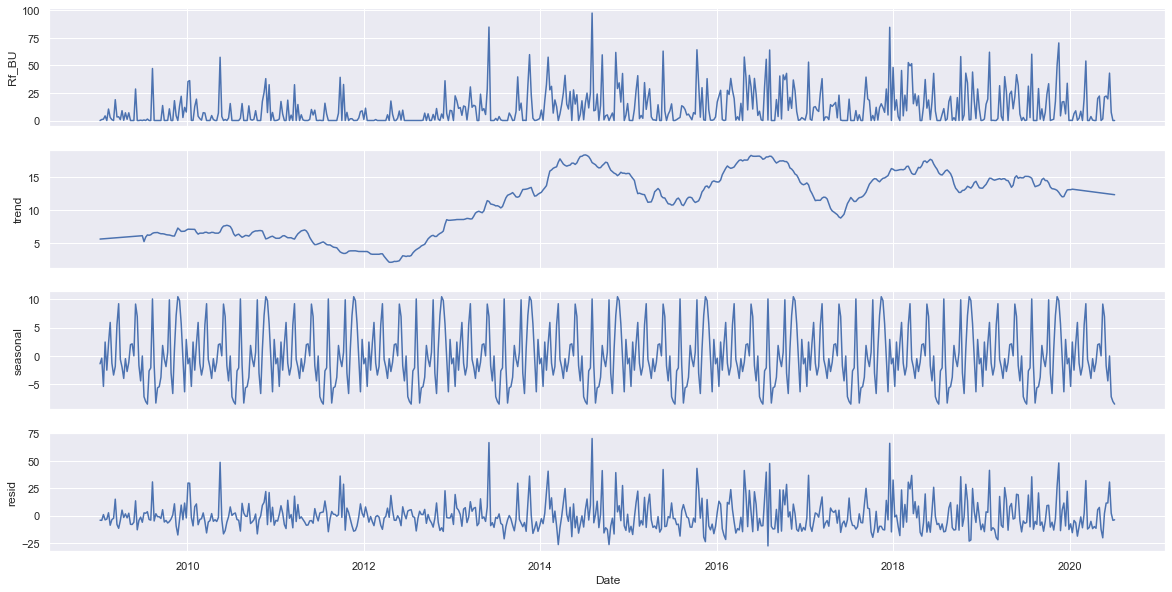

In [210]:
rainfall_decompose = eda.decompose_features(df_weekly['Rf_BU'], 52)

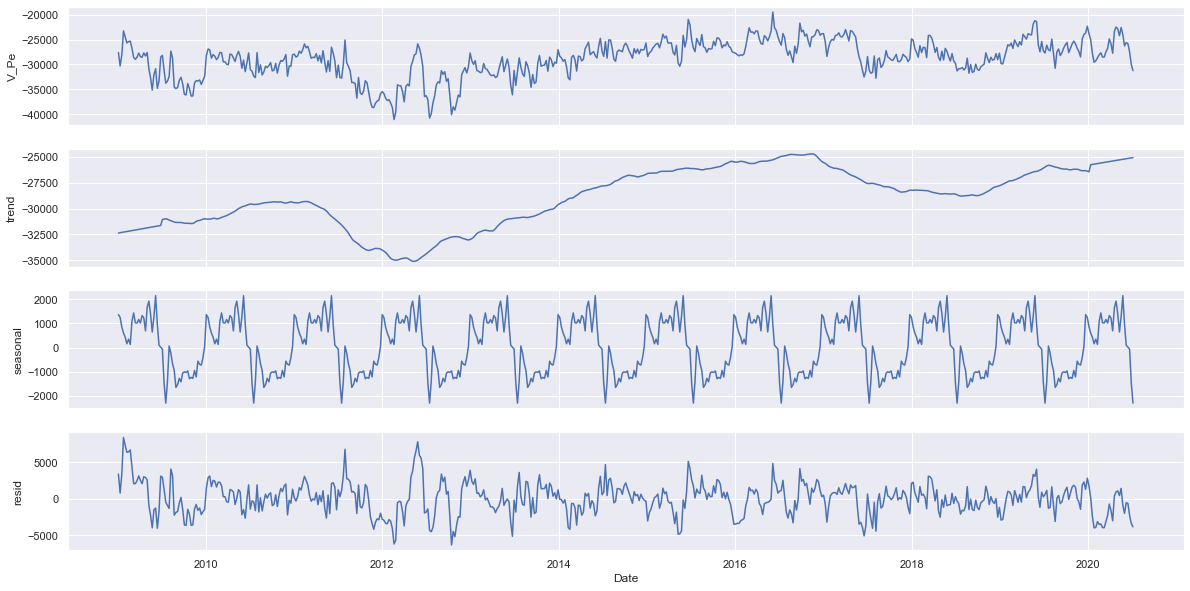

In [211]:
extraction_decompose = eda.decompose_features(df_weekly['V_Pe'], 52)

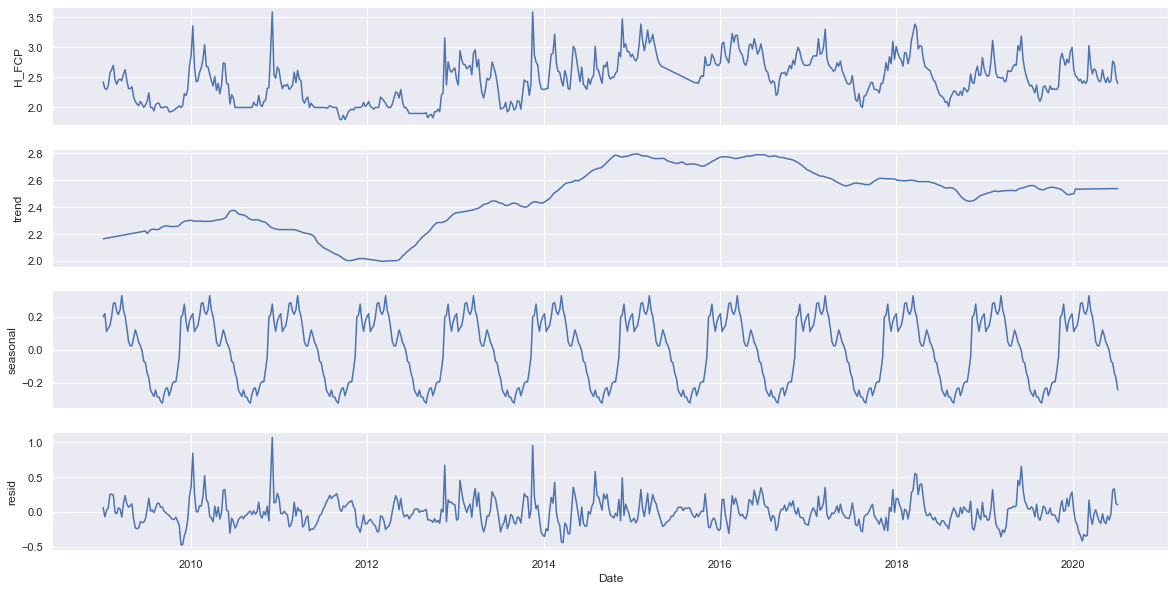

In [212]:
hydrometry_decompose = eda.decompose_features(df_weekly['H_FCP'], 52)

### Create new dataframe with all decomposed features

In [213]:
df_decomposed = pd.DataFrame(index=df_weekly.index)
features = [y_decompose, temp_decompose, rainfall_decompose, extraction_decompose, hydrometry_decompose]
for feature in features:
    df_decomposed[f'{feature.observed.name}'] = feature.observed
    df_decomposed[f'{feature.observed.name}_trend'] = feature.trend
    df_decomposed[f'{feature.observed.name}_seasonal'] = feature.seasonal

### Plot all trends of features

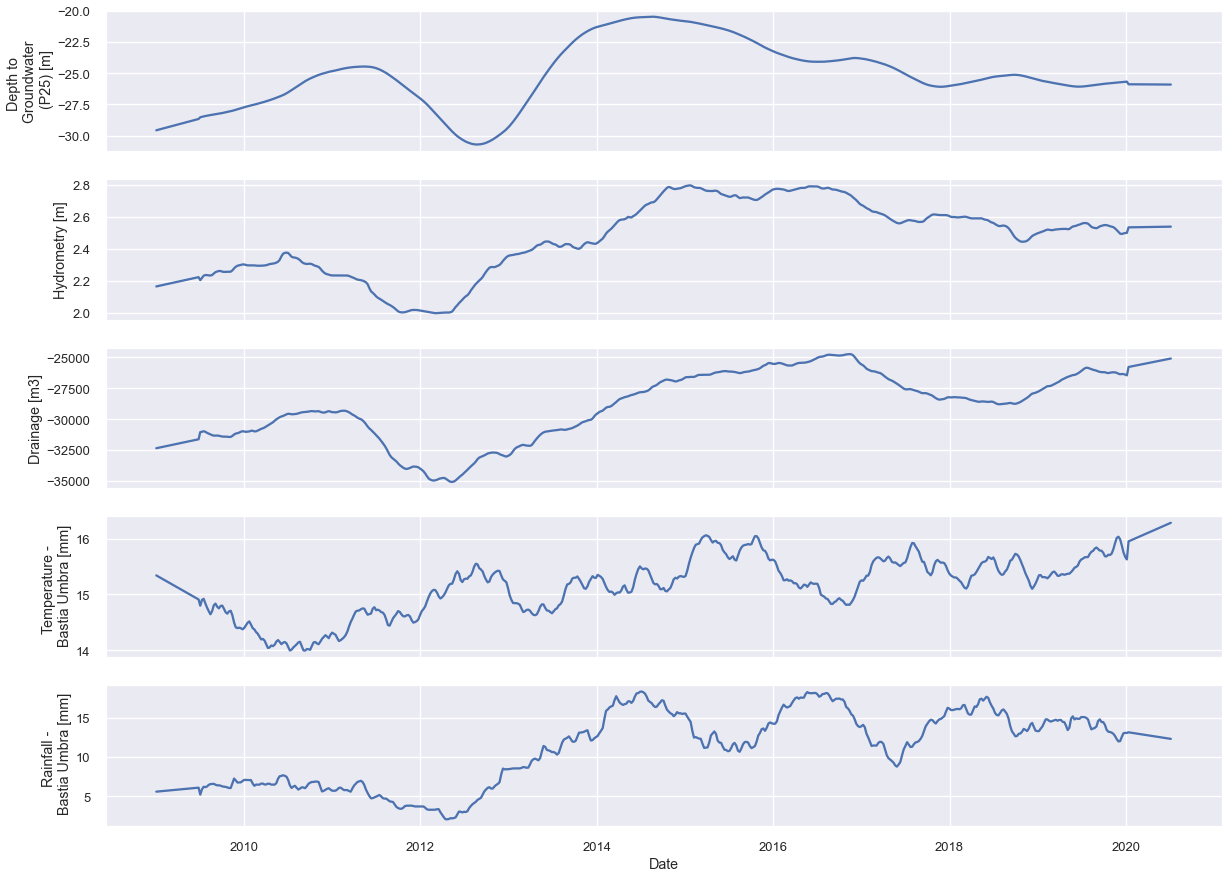

In [428]:
plot_all_trend = eda.plot_all_decomposed_trends(df_weekly, 52, '2009-01-01', '2021-01-01', columns_dict)
plot_all_trend.savefig('./graphs/trends.jpg', bbox_inches='tight')

### Create lagged trends for Volume, Hydrometry and Rainfall

In [702]:
df_decomposed['V_Pe_trend_4M'] = df_decomposed['V_Pe_trend'].shift(4*4)
df_decomposed['H_FCP_trend_3M'] = df_decomposed['H_FCP_trend'].shift(3*4)
df_decomposed['Rf_BU_trend_3M'] = df_decomposed['Rf_BU_trend'].shift(3*4)

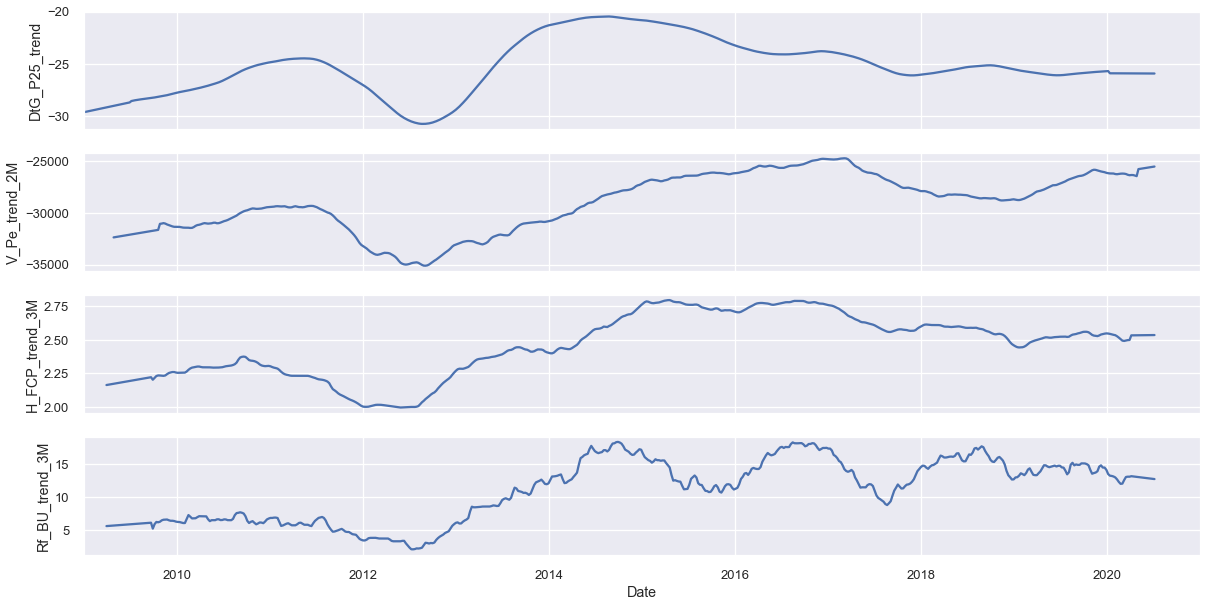

In [701]:
eda.plot_time_series(df_decomposed[['DtG_P25_trend', 'V_Pe_trend_4M', 'H_FCP_trend_3M', 'Rf_BU_trend_3M']],'2009-01-01', '2021-01-01', (20,10));

### Correlation plots of trends

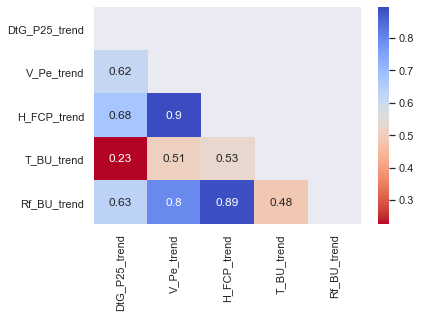

In [217]:
col_trend = ['DtG_P25_trend', 'V_Pe_trend', 'H_FCP_trend', 'T_BU_trend', 'Rf_BU_trend']
corr_trend =  df_decomposed[col_trend].corr()
sns.heatmap(corr_trend, cmap='coolwarm_r', annot=True, mask=np.triu(corr_trend))

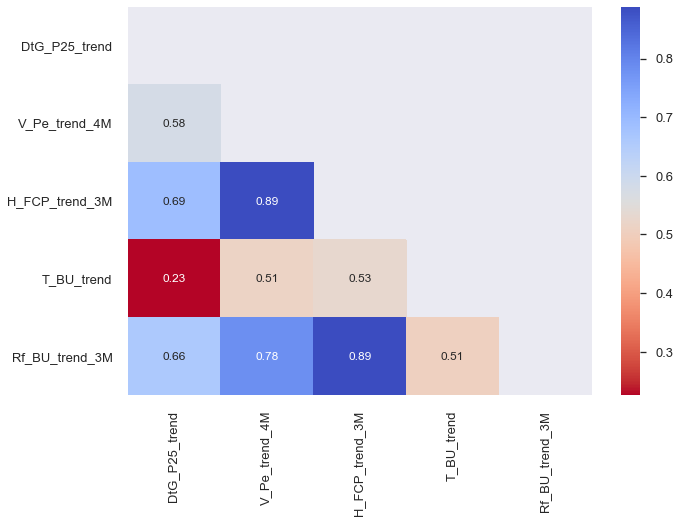

In [706]:
col_trend = ['DtG_P25_trend', 'V_Pe_trend_4M', 'H_FCP_trend_3M', 'T_BU_trend','Rf_BU_trend_3M']
corr_trend =  df_decomposed[col_trend].corr()
sns.heatmap(corr_trend, cmap='coolwarm_r', annot=True, mask=np.triu(corr_trend))

### Plot all seasonal components of features

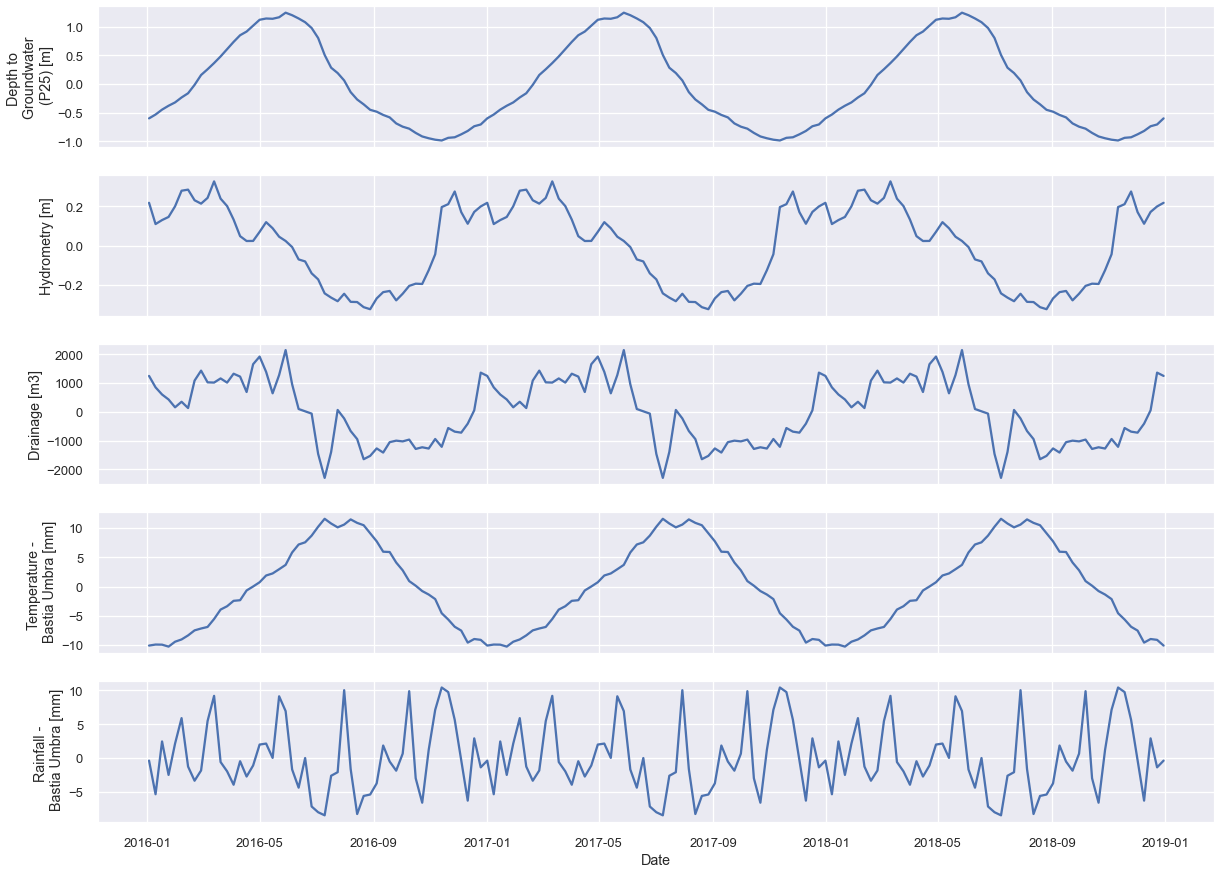

In [772]:
plot_all_seasonality = eda.plot_all_decomposed_seasonality(df_weekly, 52, '2016-01-01', '2019-01-01', columns_dict)
plot_all_seasonality.savefig('./graphs/seasonalities.jpg', bbox_inches='tight')

In [62]:
col_seasonal = ['DtG_P25_seasonal', 'V_Pe_seasonal', 'H_FCP_seasonal', 'T_BU_seasonal', 'Rf_BU_seasonal']
df_decomposed[col_seasonal].groupby(df_decomposed.index.month).agg([np.mean]).round(2)

DtG_P25_seasonal V_Pe_seasonal H_FCP_seasonal T_BU_seasonal  \
                 mean          mean           mean          mean   
Date                                                               
1               -0.42        563.49           0.16         -9.87   
2               -0.04        797.03           0.25         -7.88   
3                0.48       1138.14           0.23         -4.47   
4                0.95       1342.23           0.05         -0.66   
5                1.17       1334.15           0.06          2.98   
6                1.03        -71.77          -0.10          7.91   
7                0.29      -1052.18          -0.25         10.76   
8               -0.32      -1170.83          -0.30         10.13   
9               -0.61      -1150.90          -0.25          5.28   
10              -0.87      -1155.67          -0.17         -0.16   
11              -0.95       -858.86           0.16         -5.11   
12              -0.72        281.91           0.17         -9.13   

     Rf_BU_seasonal  
               mean  
Date                 
1             -0.24  
2              0.38  
3              1.29  
4             -0.78  
5              3.81  
6             -4.07  
7             -2.40  
8             -4.22  
9             -0.06  
10             0.52  
11             6.85  
12            -1.21

## Relative feature lags 
- Groundwater Level - Maximum in Mai/June - Minimum in Oktober/November
- Drainage (inversed negative) - Minimum in March/April - Maximum in June-August
- Hydrometry - Maximum in February/March - Minimum in June - August
- Temperatur - Maximum in June-August - Minimum in January/December
- Rainfall - Maximum in November, Minimum in June - August 

- Temperature lags 2 Month behind Groundwater Level
- Drainage lags 1 Month behind Groundwater Level
- Hydrometry lag -3 Month behind Groundwater Level

### Lagged versions of seasonality H_FCP (3 month), V_Pe (1 month), T_Bu (2 month reverse)

In [1161]:
df_decomposed['V_Pe_seasonal_1M'] = df_decomposed['V_Pe_seasonal'].shift(2*4)
df_decomposed['H_FCP_seasonal_3M'] = df_decomposed['H_FCP_seasonal'].shift(3*4)
df_decomposed['T_BU_seasonal_2Mr'] = df_decomposed['T_BU_seasonal'].shift(-2*4)

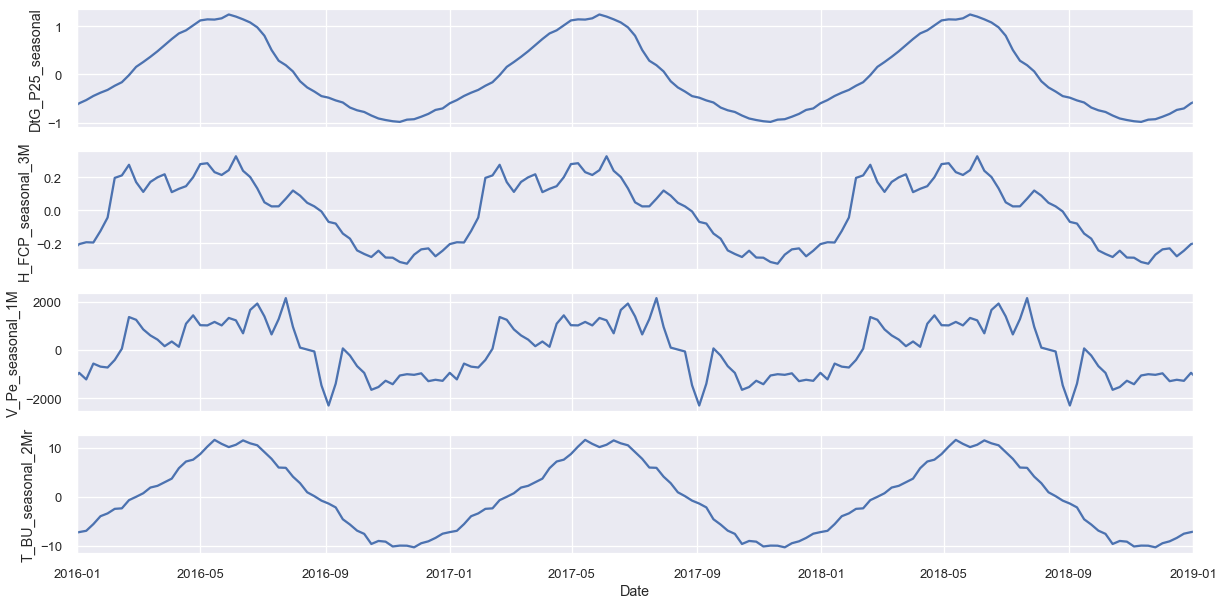

In [1162]:
eda.plot_time_series(df_decomposed[['DtG_P25_seasonal', 'H_FCP_seasonal_3M', 'V_Pe_seasonal_1M', 'T_BU_seasonal_2Mr']],'2016-01-01', '2019-01-01' ,plotsize=(20,10));

### Correlation plots of seasonality

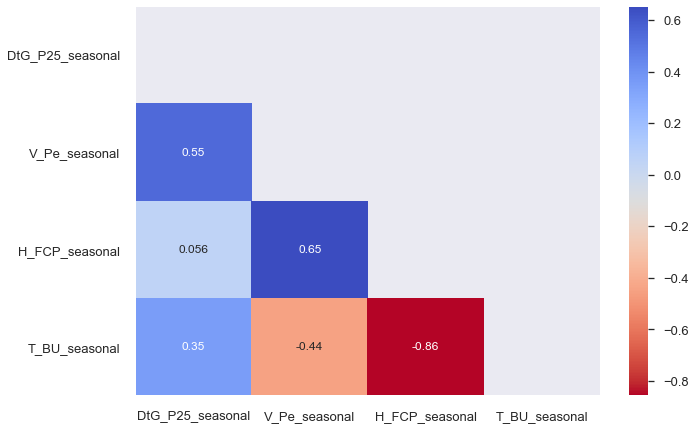

In [703]:
col_seas = ['DtG_P25_seasonal', 'V_Pe_seasonal', 'H_FCP_seasonal', 'T_BU_seasonal']
corr_seas =  df_decomposed[col_seas].corr()
sns.heatmap(corr_seas, cmap='coolwarm_r', annot=True, mask=np.triu(corr_seas))

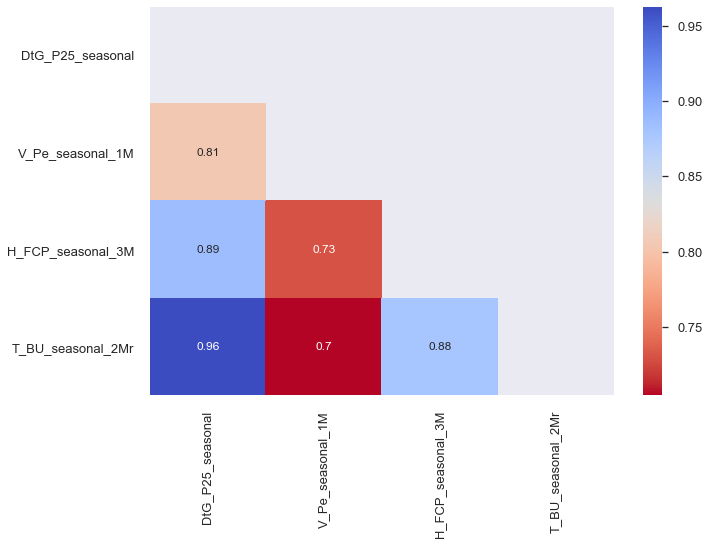

In [711]:
col_seas = ['DtG_P25_seasonal', 'V_Pe_seasonal_1M', 'H_FCP_seasonal_3M', 'T_BU_seasonal_2Mr']
corr_seas =  df_decomposed[col_seas].corr()
sns.heatmap(corr_seas, cmap='coolwarm_r', annot=True, mask=np.triu(corr_seas))

## Manual decompose

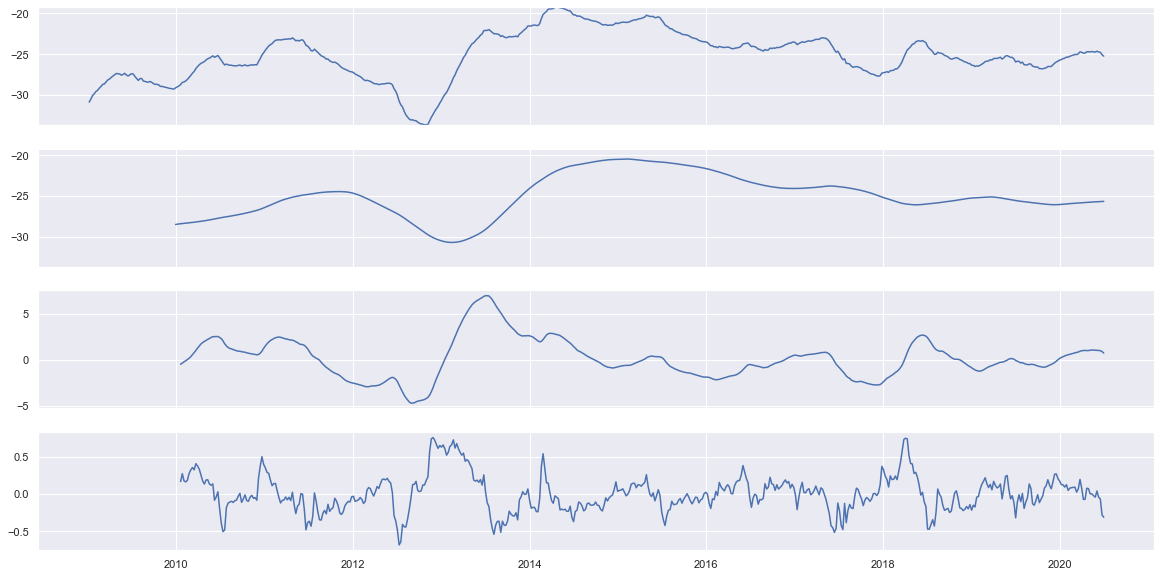

In [112]:
dec_series = df_decomposed.loc['2009-01-01':,'DtG_P25']
trend, seasonality, residual = eda.ma_decompose(dec_series, 52, 4)
eda.plot_decomposition(dec_series, trend, seasonality, residual)

## Train-Test-Split

In [1007]:
# Train-Test-Split
df_imputed = df_imputed.loc['2009':]

train = df_weekly[:-120]
test = df_weekly[-120:]
y_train = train['DtG_P25']
y_test = test['DtG_P25']

prediction_window = 4

## Baseline Model

### Mean

In [1008]:
y_pred_mean = pd.Series(y_train.mean(), index=test.index)

In [1009]:
## walkforward baseline
baseline_wlk_fwd = walkforward_baseline(y_train, y_test, 'W', prediction_window)

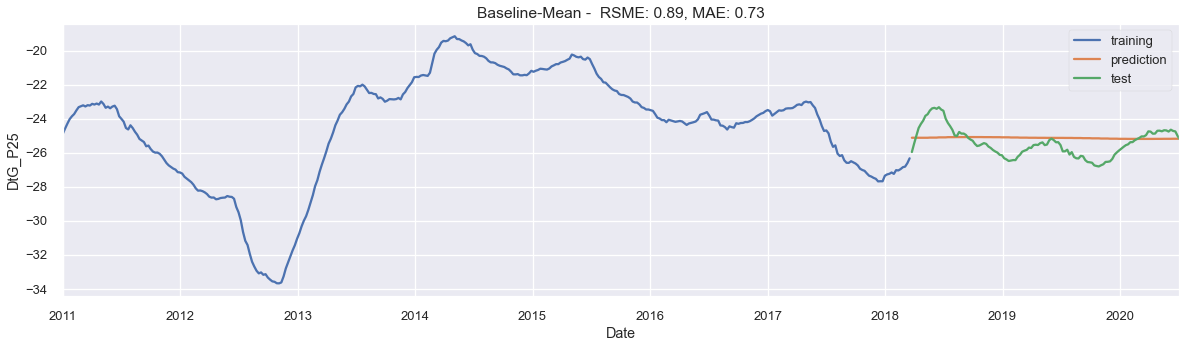

In [1010]:
plot_model_performance(y_train, baseline_wlk_fwd, y_test, 'Baseline-Mean', '2011-01-01', '2020-07-01');

### Naive Approach

In [1011]:
y_pred_naive = pd.Series(y_train[-1], index=test.index)

In [1012]:
naive_wlk_fwd = walkforward_naive(y_train, y_test, 'W', prediction_window)

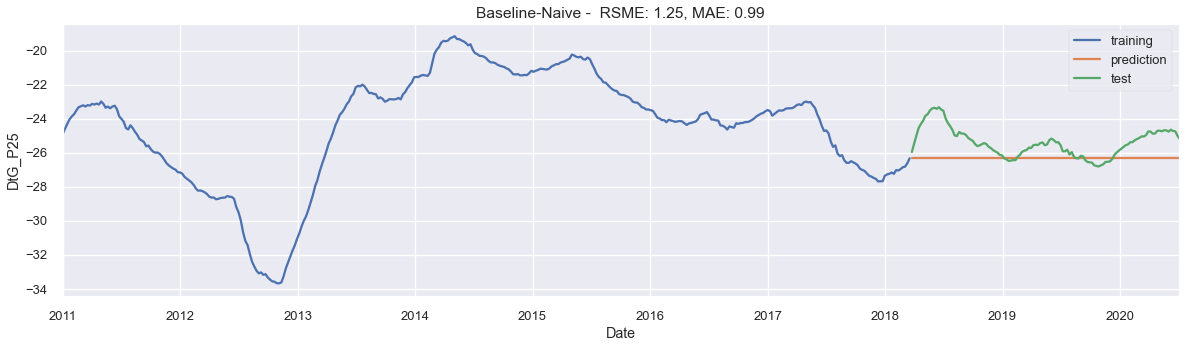

In [1013]:
naive_plot = plot_model_performance(y_train, y_pred_naive, y_test, 'Baseline-Naive', '2011-01-01', '2020-07-01')
naive_plot.savefig('./graphs/naive_model.jpg', bbox_inches='tight')

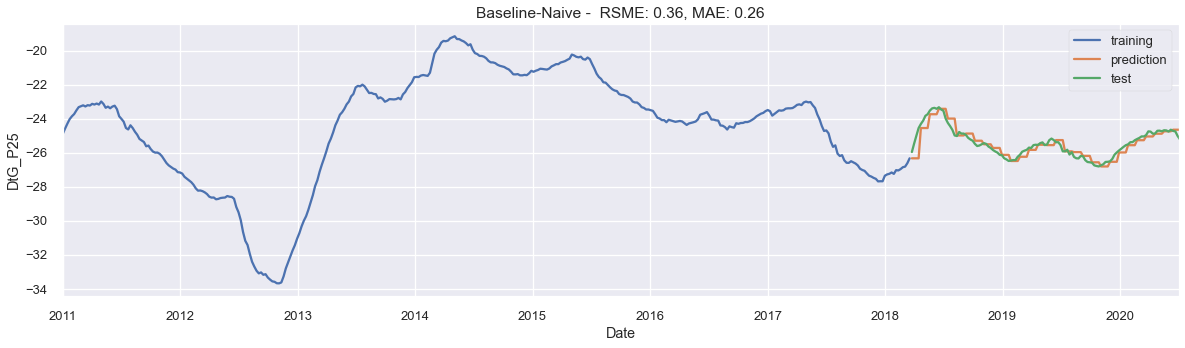

In [1014]:
naive_plot_wlk = plot_model_performance(y_train, naive_wlk_fwd, y_test, 'Baseline-Naive', '2011-01-01', '2020-07-01')
naive_plot_wlk.savefig('./graphs/naive_model_wlk.jpg', bbox_inches='tight')

## ARIMA - univariant

### Adfuller Test for stationarity

In [1015]:
result = adfuller(y_train)
print('ADF Statistic: %f' % result[0] + '\np-value: %f' % result[1])

ADF Statistic: -2.383133
p-value: 0.146554


### Differencing to get a stationary series

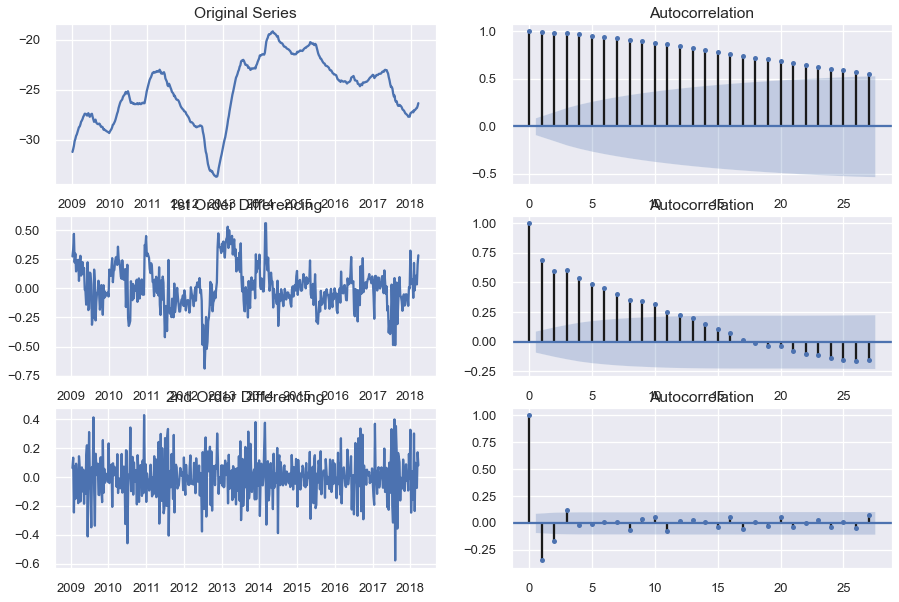

In [1016]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(15,10))
axes[0, 0].plot(y_train)
axes[0, 0].set_title('Original Series')
plot_acf(y_train, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y_train.diff().dropna())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(y_train.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y_train.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y_train.diff().dropna().diff().dropna(), ax=axes[2, 1])

plt.show()

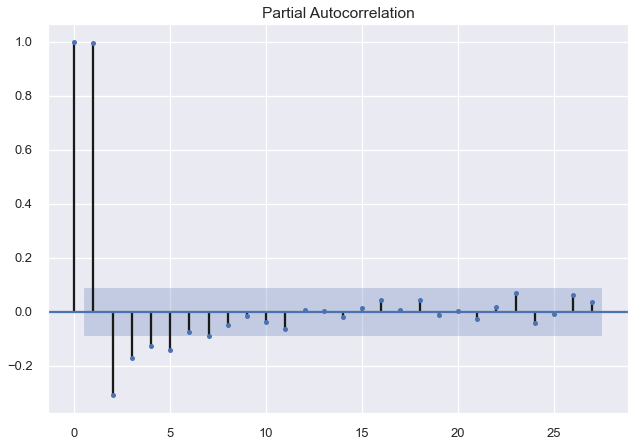

In [1017]:
plot_pacf(y_train);

### ARIMA Model

In [1018]:
mod = ARIMA(y_train, order=(1,1,1), freq='W')
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.DtG_P25   No. Observations:                  480
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 310.834
Method:                       css-mle   S.D. of innovations              0.126
Date:                Thu, 18 Feb 2021   AIC                           -613.667
Time:                        18:50:29   BIC                           -596.972
Sample:                    01-11-2009   HQIC                          -607.105
                         - 03-18-2018                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0214      0.037      0.571      0.568      -0.052       0.095
ar.L1.D.DtG_P25     0.9257      0.022     41.383      0.000       0.882       0.970
ma.L1.D.DtG_P25    -0.5090      0.050    -10.133      0.000      -0.607      -0.411
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0802           +0.0000j            1.0802            0.0000
MA.1            1.9645           +0.0000j            1.9645            0.0000
-----------------------------------------------------------------------------
"""

#### Plot residuals

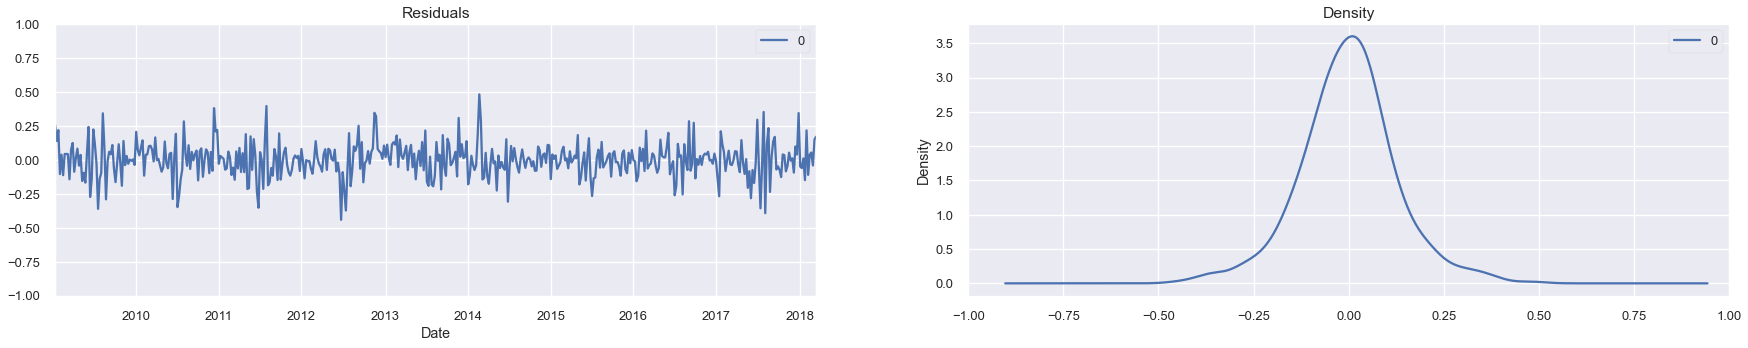

In [1019]:
residuals = pd.DataFrame(res.resid)
f, ax = plt.subplots(1, 2, figsize=(30,5))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].set_ylim([-1,1])
residuals.plot(title='Density', kind='kde', ax=ax[1])
ax[1].set_xlim([-1,1])
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [120, 90]

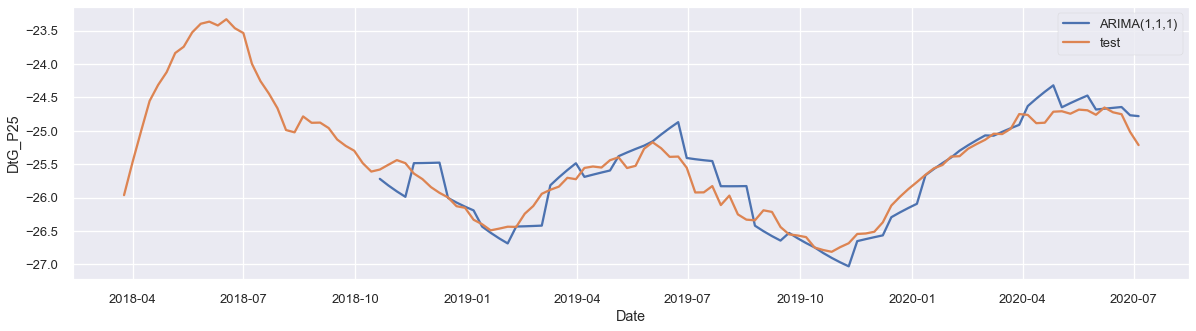

In [1020]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
#sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = arima_wlk_fwd.index, y=arima_wlk_fwd, label='ARIMA(1,1,1)')
sns.lineplot(x = test.index, y=y_test, label='test')
ax.set_title(f'ARIMA (1,1,1) - R2: {round(r2_score(y_test, arima_wlk_fwd),3)}, RSME: {RSME(y_test, arima_wlk_fwd)}, MAE: {MAE(y_test, arima_wlk_fwd)}')
plt.show()

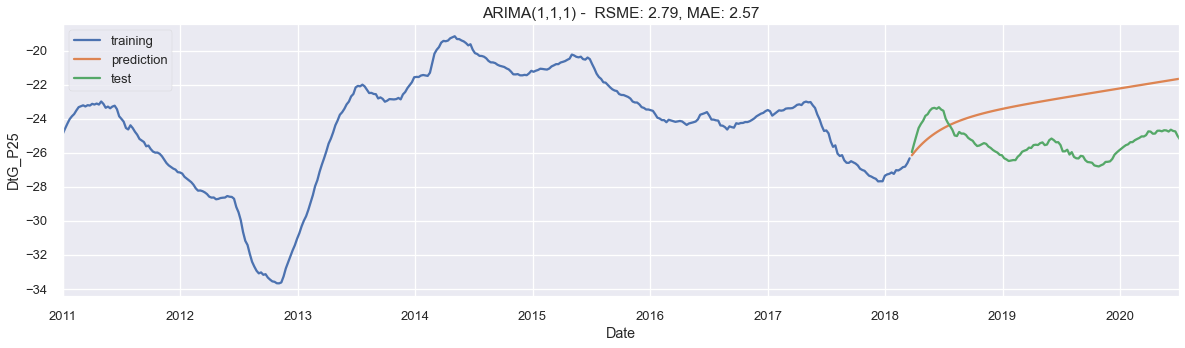

In [1021]:
plot_arima = plot_model_performance(y_train, pd.Series(res.forecast(len(test.index))[0], index=test.index), y_test, 'ARIMA(1,1,1)', '2011-01-01', '2020-07-01');
plot_arima.savefig('./graphs/ARIMA_model_.jpg', bbox_inches='tight')

In [1022]:
arima_wlk_fwd = walkforward_ARIMA(y_train, y_test, (1,1,1), 'W', prediction_window)

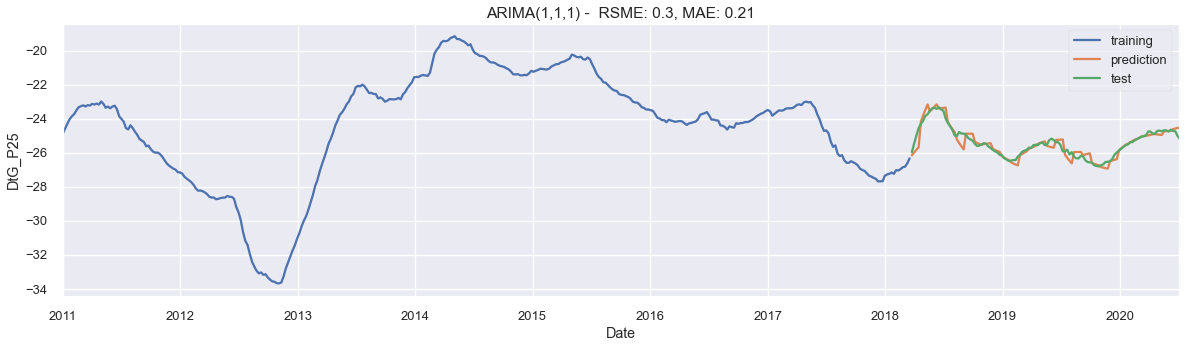

In [1023]:
Arima_wlk_plot = plot_model_performance(y_train, arima_wlk_fwd, y_test, 'ARIMA(1,1,1)', '2011-01-01', '2020-07-01')
Arima_wlk_plot.savefig('./graphs/ARIMA_model_wlk_.jpg', bbox_inches='tight')

## Facebook Prophet

In [1024]:
from fbprophet import Prophet

In [1025]:
y_train_prophet = y_train.reset_index()
y_train_prophet.columns = ['ds', 'y']

In [1026]:
m_prophet_1 = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
m_prophet_1.fit(y_train_prophet)

In [1027]:
future_frame = m_prophet_1.make_future_dataframe(periods=len(y_test), freq='W', include_history=False)
prophet_simple = m_prophet_1.predict(future_frame)

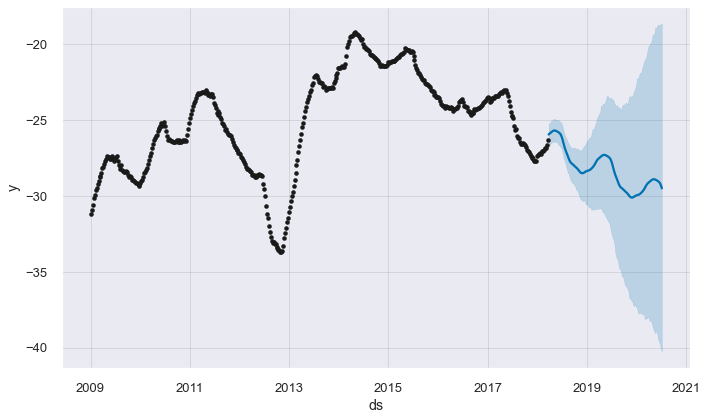

In [1028]:
m1 = m_prophet_1.plot(prophet_simple)

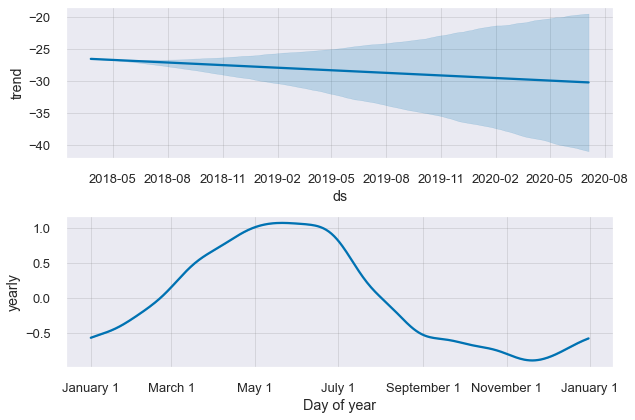

In [1029]:
comp = m_prophet_1.plot_components(prophet_simple)

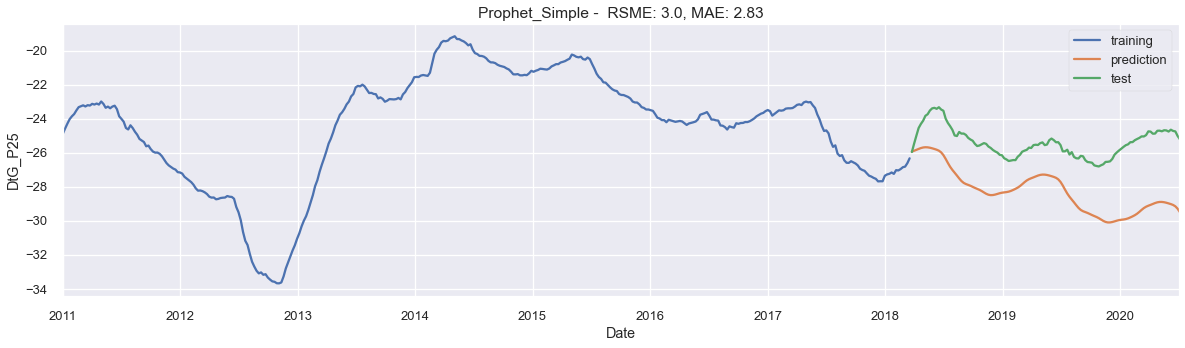

In [1030]:
plot_prohet_simple = plot_model_performance(y_train, prophet_simple.set_index('ds').yhat, y_test, 'Prophet_Simple', '2011-01-01', '2020-07-01');
plot_prohet_simple.savefig('./graphs/prophet_simple_model.jpg', bbox_inches='tight')

In [1031]:
prophet_wlk_fwd = walkforward_Prophet_uni(y_train, y_test, 'W', prediction_window)

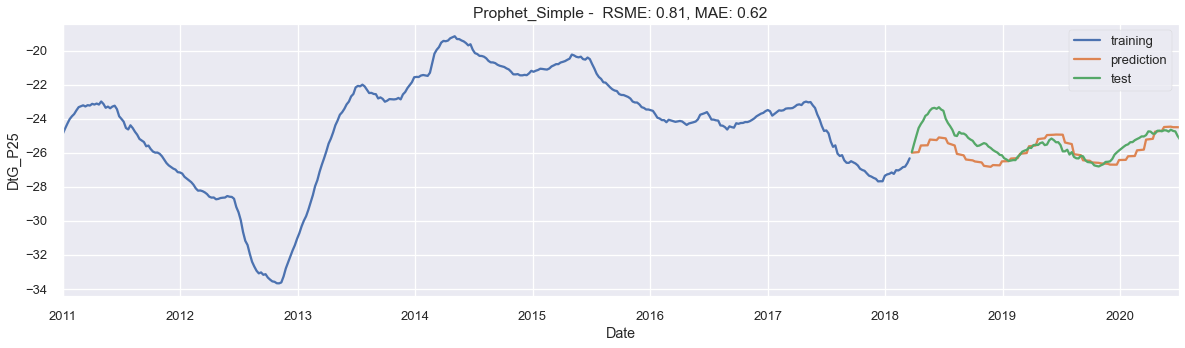

In [1159]:
plot_prohet_simple_wlk =plot_model_performance(y_train, prophet_wlk_fwd, y_test, 'Prophet_Simple', '2011-01-01', '2020-07-01');
plot_prohet_simple_wlk.savefig('./graphs/prophet_simple_model_wlk.jpg', bbox_inches='tight')

## Multi-Variate

## Prophet with Addition of regressors

In [1033]:
train_prophet = train_trend.dropna().reset_index()
train_prophet.rename(columns = {'Date' : 'ds', 'DtG_P25' : 'y'}, inplace=True)

In [1034]:
regressors = ['V_Pe', 'T_BU', 'Rf_BU', 'H_FCP']
m_prophet_2 = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
for regressor in regressors:
    m_prophet_2.add_regressor(regressor, mode='additive')
m_prophet_2.fit(train_prophet)

In [1035]:
future_frame = m_prophet_2.make_future_dataframe(periods=len(test), freq='W', include_history=False)

In [1036]:
future_frame = future_frame.join(test_trend[regressors].reset_index(drop=True))

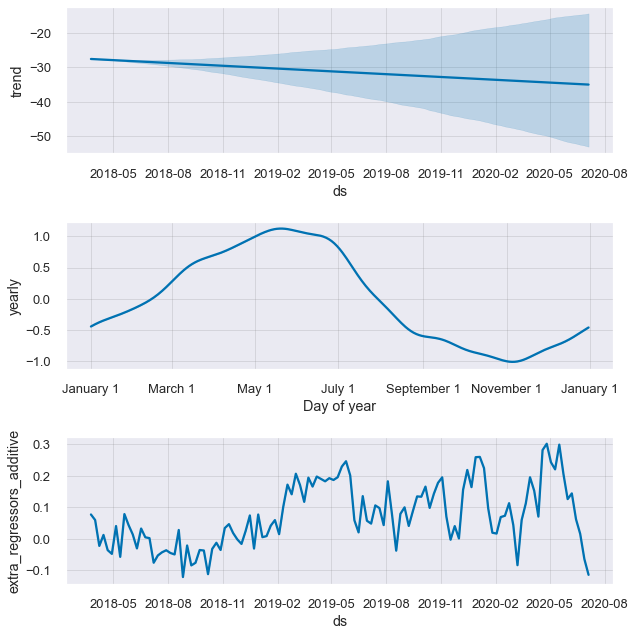

In [1037]:
prophet_complex = m_prophet_2.predict(future_frame)
fig = m_prophet_2.plot_components(prophet_complex)

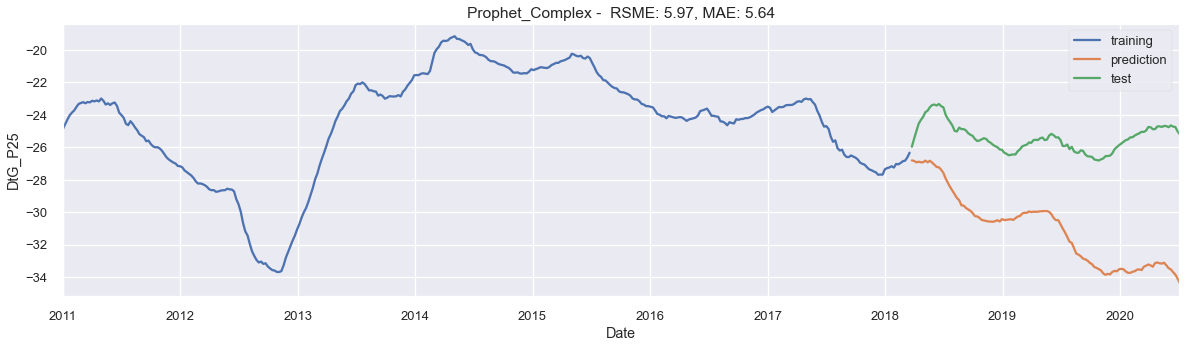

In [1038]:
plot_prohet_regressor = plot_model_performance(y_train, prophet_complex.set_index('ds').yhat, y_test, 'Prophet_Complex', '2011-01-01', '2020-07-01');
plot_prohet_regressor.savefig('./graphs/prophet_regressor_model.jpg', bbox_inches='tight')

## CatBoost Trees

In [1146]:
width = 52

df_trend = df_weekly.copy()

prediction_window = 4

for column in df_trend:
    lag = df_trend.shift(width - 1)
    df_trend[f'{column}_trend'] = lag[column].rolling(window=width).mean()

df_trend['V_Pe_trend_4M'] = df_trend['V_Pe_trend'].shift(4*4)
df_trend['H_FCP_trend_6M'] = df_trend['H_FCP_trend'].shift(6*4)
df_trend['Rf_BU_trend_6M'] = df_trend['Rf_BU_trend'].shift(6*4)
df_trend['V_Pe_seasonal_1M'] = df_decomposed['V_Pe_seasonal'].shift(1*4)
df_trend['H_FCP_seasonal_3M'] = df_decomposed['H_FCP_seasonal'].shift(3*4)
df_trend['T_BU_seasonal_2Mr'] = df_decomposed['T_BU_seasonal'].shift(-2*4)

df_trend['DtG_P25_lag_4wk'] = df_trend['DtG_P25'].shift(prediction_window)
df_trend['DtG_P25_trend_lag_4wk'] = df_trend['DtG_P25_trend'].shift(prediction_window)
df_trend['T_BU_lag_4wk'] = df_trend['T_BU'].shift(-2*4)
df_trend['V_Pe_lag_4wk'] = df_trend['V_Pe'].shift(1*4)
df_trend['H_FCP_lag_4wk'] = df_trend['H_FCP'].shift(3*4)

train_trend = df_trend[:-120]
test_trend = df_trend[-120:]
y_train_trend = train_trend['DtG_P25']
y_test_trend = test_trend['DtG_P25']

In [1147]:
from catboost import CatBoostRegressor

### Features for general Catboost Model

In [1173]:
#x_columns = ['V_Pe', 'T_BU', 'Rf_BU', 'H_FCP']
#x_columns = ['V_Pe', 'T_BU', 'Rf_BU', 'H_FCP', 'Rf_BU_trend_6M', 'V_Pe_trend_4M', 'H_FCP_trend_6M']
x_columns = ['T_BU_trend', 'Rf_BU_trend', 'V_Pe_trend', 'H_FCP_trend' ,'T_BU_seasonal_2Mr', 'H_FCP_seasonal_3M', 'V_Pe_seasonal_1M']
y_train = train_trend['DtG_P25']
X_train = train_trend[x_columns]
X_train = X_train.join(pd.get_dummies(create_season(X_train.index), drop_first=True).set_index(X_train.index))
#X_train['year'] = X_train.index.year

y_test = test_trend['DtG_P25']
X_test = test_trend[x_columns]
X_test = X_test.join(pd.get_dummies(create_season(X_test.index), drop_first=True).set_index(X_test.index))
#X_test['year'] = X_test.index.year

In [1174]:
boost = CatBoostRegressor(iterations=200, learning_rate=0.05, depth=3, verbose=False)

In [1175]:
boost.fit(X_train, y_train)

In [1176]:
df_trend.tail()

DtG_P25     H_FCP          V_Pe       T_BU  Rf_BU  \
Date                                                              
2020-06-07 -24.652857  2.442857 -25637.965714  19.271429   19.6   
2020-06-14 -24.724286  2.771429 -25804.841143  18.428571   43.0   
2020-06-21 -24.752857  2.728571 -27476.496000  20.385714    7.4   
2020-06-28 -25.017143  2.485714 -29972.900571  24.928571    0.0   
2020-07-05 -25.215000  2.400000 -31240.512000  27.100000    0.0   

            DtG_P25_trend  H_FCP_trend    V_Pe_trend  T_BU_trend  Rf_BU_trend  \
Date                                                                            
2020-06-07     -25.457404     2.488736 -27899.882110   15.176923    13.403846   
2020-06-14     -25.494354     2.493681 -27824.574066   15.215934    13.292308   
2020-06-21     -25.533118     2.498077 -27776.737582   15.315659    13.292308   
2020-06-28     -25.570151     2.501374 -27707.585143   15.366484    13.300000   
2020-07-05     -25.602184     2.505495 -27616.852088   15.326374    13.900000   

            ...  H_FCP_trend_6M  Rf_BU_trend_6M  V_Pe_seasonal_1M  \
Date        ...                                                     
2020-06-07  ...        2.557967       15.696154        643.576267   
2020-06-14  ...        2.551374       15.519231       1277.613464   
2020-06-21  ...        2.545330       15.184615       2145.976145   
2020-06-28  ...        2.540659       15.400000        957.357770   
2020-07-05  ...        2.542033       15.773077         97.772077   

            H_FCP_seasonal_3M  T_BU_seasonal_2Mr  DtG_P25_lag_4wk  \
Date                                                                
2020-06-07           0.238583                NaN       -24.745714   
2020-06-14           0.200989                NaN       -24.684286   
2020-06-21           0.132328                NaN       -24.694286   
2020-06-28           0.048157                NaN       -24.761429   
2020-07-05           0.023567                NaN       -24.652857   

            DtG_P25_trend_lag_4wk  T_BU_lag_4wk  V_Pe_lag_4wk  H_FCP_lag_4wk  
Date                                                                          
2020-06-07             -25.311717           NaN -24236.681143       2.700000  
2020-06-14             -25.347706           NaN -22578.048000       2.557143  
2020-06-21             -25.382431           NaN -23999.698286       2.642857  
2020-06-28             -25.417788           NaN -26276.955429       2.614286  
2020-07-05             -25.457404           NaN -25637.965714       2.500000  

[5 rows x 21 columns]

### Prediction on Training Set

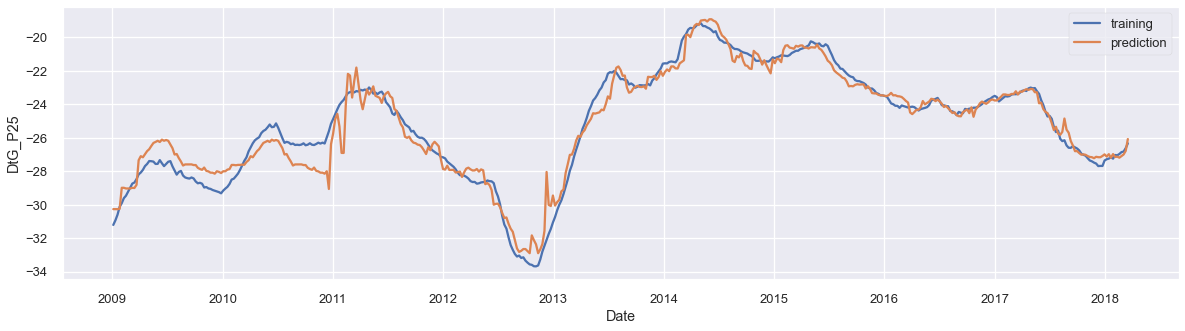

In [1177]:
yhat = pd.Series(boost.predict(X_train), index=X_train.index)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = yhat.index, y=yhat, label='prediction')
plt.show()

### Feature Importance

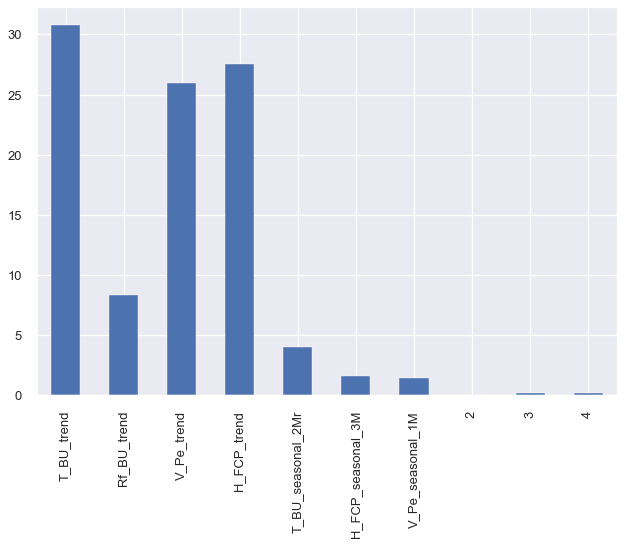

In [1183]:
pd.Series(boost.feature_importances_, index=X_train.columns).plot(kind='bar')
plt.savefig('./graphs/features_importance_catboost_general_trend_seasonality.jpg', bbox_inches='tight')

### Crossvalidation

In [1179]:
X_training, X_validation = cv_split(X_train, 5)
y_training, y_validation = cv_split(y_train, 5)

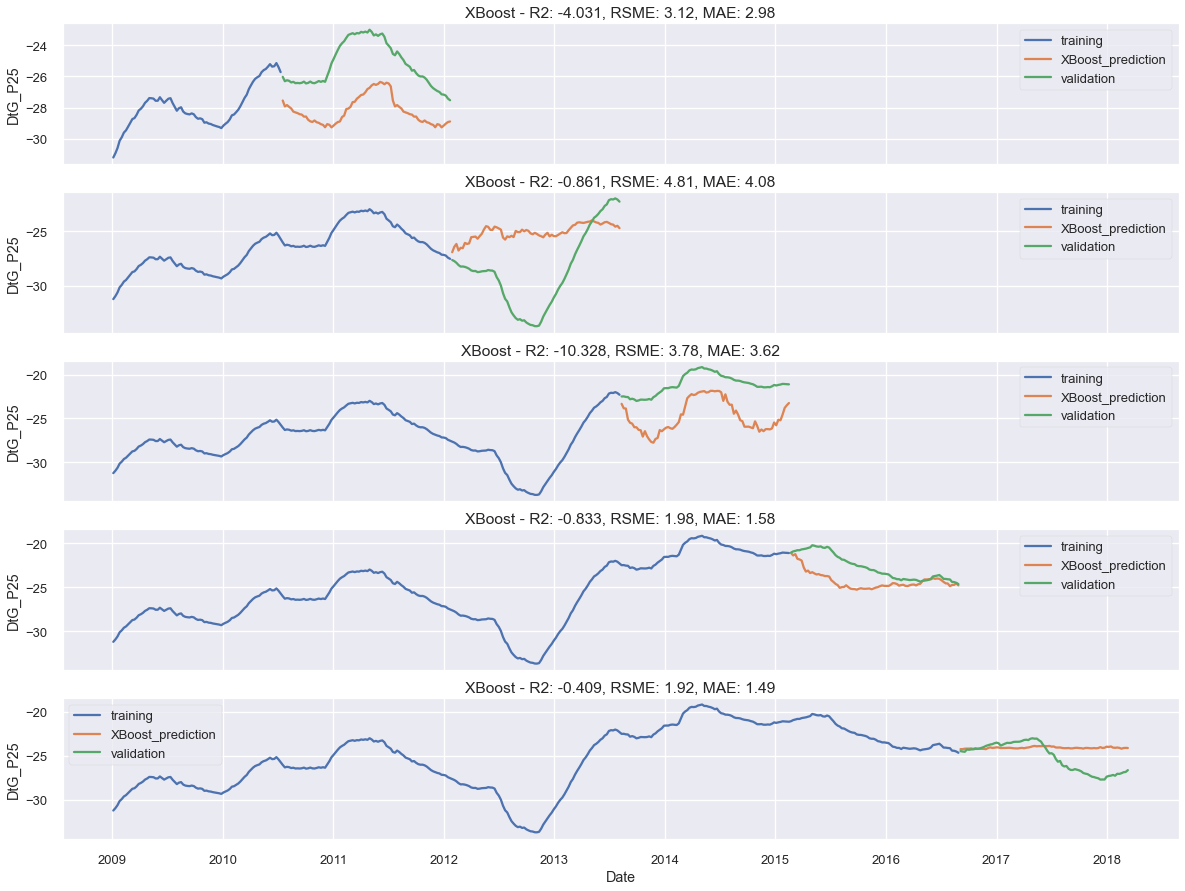

In [1180]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(20,15), sharex=True)
for i in range(5):
    boost.fit(X_training[i], y_training[i])
    prediction = pd.Series(boost.predict(X_validation[i]), index=X_validation[i].index)
    
    sns.lineplot(x = y_training[i].index, y=y_training[i], label='training', ax=ax[i])
    sns.lineplot(x = prediction.index, y=prediction, label='XBoost_prediction', ax=ax[i])
    sns.lineplot(x = y_validation[i].index, y=y_validation[i], label='validation', ax=ax[i])
    ax[i].set_title(f'XBoost - R2: {round(r2_score(y_validation[i], prediction),3)}, RSME: {RSME(y_validation[i], prediction)}, MAE: {MAE(y_validation[i], prediction)}')
plt.show()

### Catboost on Test

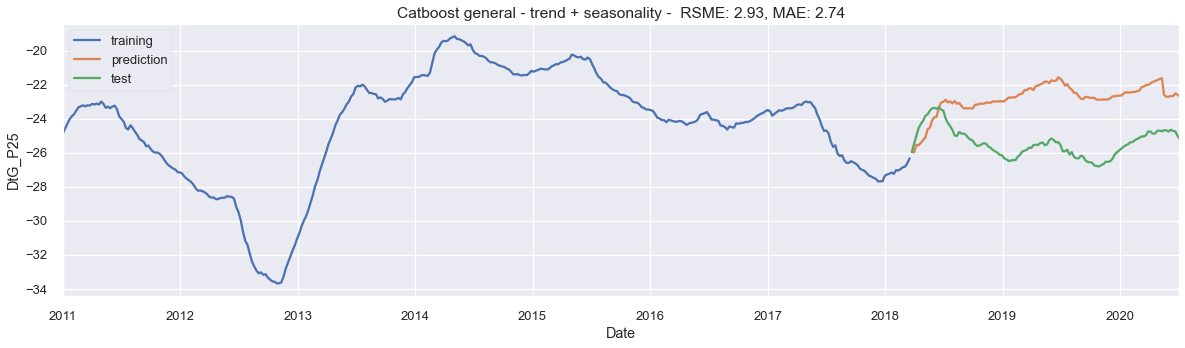

In [1185]:
boost.fit(X_train, y_train)
boost_forecast = pd.Series(boost.predict(X_test), index=X_test.index)

catboost_general = plot_model_performance(y_train, boost_forecast, y_test, 'Catboost general - trend + seasonality', '2011-01-01', '2020-07-01');
catboost_general.savefig('./graphs/catboost_general_trend_seasonality.jpg', bbox_inches='tight')

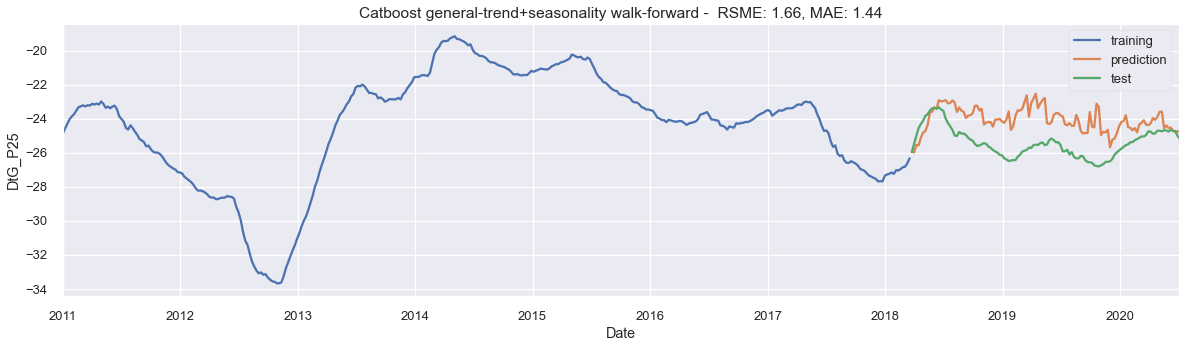

In [1186]:
boost_wlk_fwd = walkforward_Catboost(boost, X_train, y_train, X_test, y_test, 'W', prediction_window)

catboost_general_wlk = plot_model_performance(y_train, boost_wlk_fwd, y_test, 'Catboost general-trend+seasonality walk-forward', '2011-01-01', '2020-07-01')
catboost_general_wlk.savefig('./graphs/catboost_general_trend_seasonality_wlk.jpg', bbox_inches='tight')

## CatBoost with lagged features

In [1085]:
## Lagged features of X
x_columns = ['V_Pe', 'T_BU', 'Rf_BU', 'H_FCP', 'DtG_P25_lag_4wk', 'H_FCP_lag_4wk']
#x_columns = ['T_BU_trend','Rf_BU_trend_2M', 'V_Pe_trend_4M', 'H_FCP_trend_2M', 'DtG_P25_shifted', 'H_FCP_shifted']

y_train_lagged = train_trend['DtG_P25']
X_train_lagged = train_trend[x_columns]
X_train_lagged = X_train_lagged.join(pd.get_dummies(create_season(X_train.index), drop_first=True).set_index(X_train.index))
X_train_lagged['year'] = X_train_lagged.index.year

y_test_lagged = test_trend['DtG_P25']
X_test_lagged = test_trend[x_columns]
X_test_lagged = X_test_lagged.join(pd.get_dummies(create_season(X_test_lagged.index), drop_first=True).set_index(X_test.index))
X_test_lagged['year'] = X_test.index.year

In [1086]:
boost = CatBoostRegressor(iterations=200, learning_rate=0.02, depth=3, verbose=False)
boost.fit(X_train_lagged, y_train_lagged)
yhat = pd.Series(boost.predict(X_train_lagged), index=X_train_lagged.index)

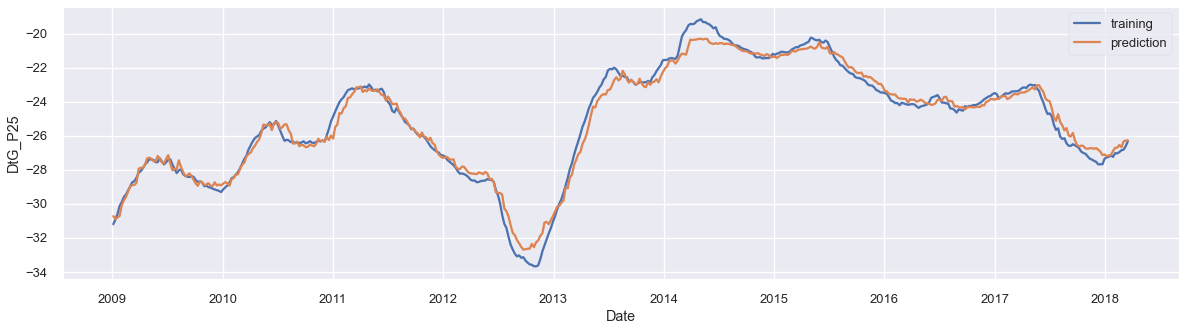

In [1087]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train_lagged.index, y=y_train_lagged, label='training')
sns.lineplot(x = yhat.index, y=yhat, label='prediction')
plt.show()

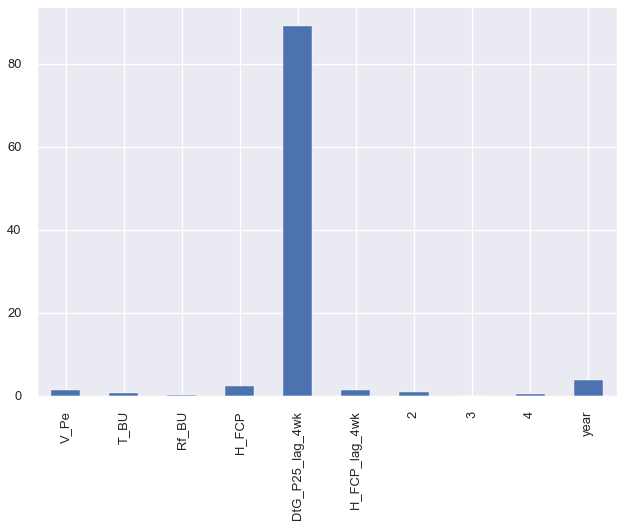

In [1089]:
pd.Series(boost.feature_importances_, index=X_train_lagged.columns).plot(kind='bar')
plt.savefig('./graphs/features_importance_catboost_lagged_tre.jpg', bbox_inches='tight')

### Crossvalidation

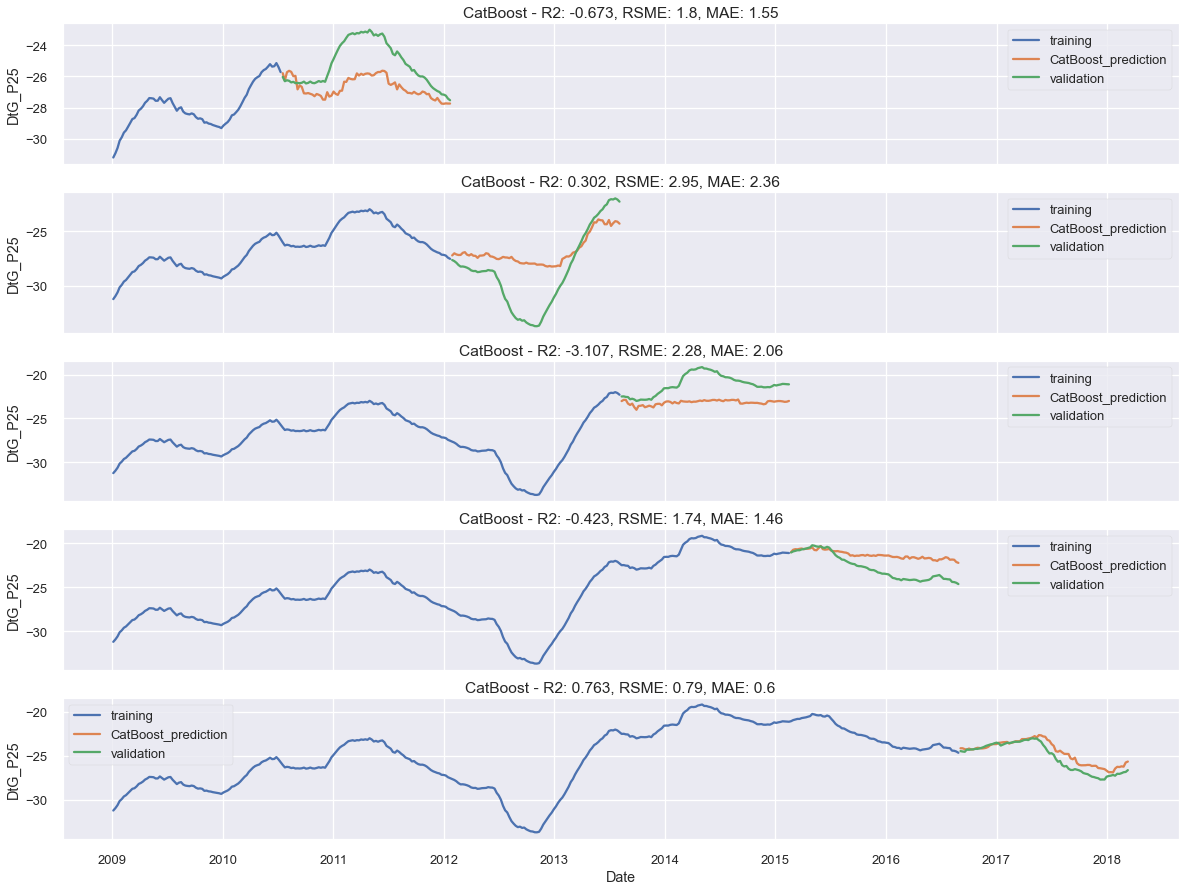

In [1083]:
plot_CV_Catboost(boost, X_train_lagged, y_train_lagged, 5)

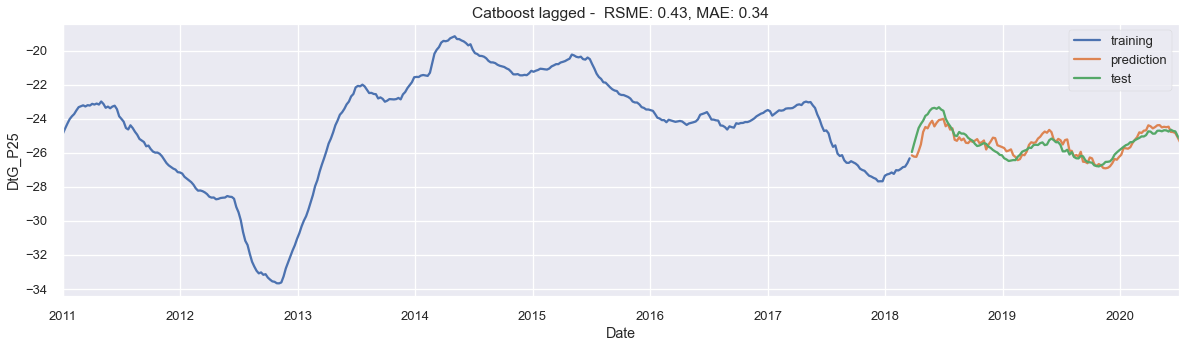

In [1157]:
boost.fit(X_train_lagged, y_train_lagged)
boost_forecast = pd.Series(boost.predict(X_test_lagged), index=X_test.index)

catboost_lag = plot_model_performance(y_train, boost_forecast, y_test, 'Catboost lagged', '2011-01-01', '2020-07-01');
catboost_lag.savefig('./graphs/catboost_lag_only_features.jpg', bbox_inches='tight')

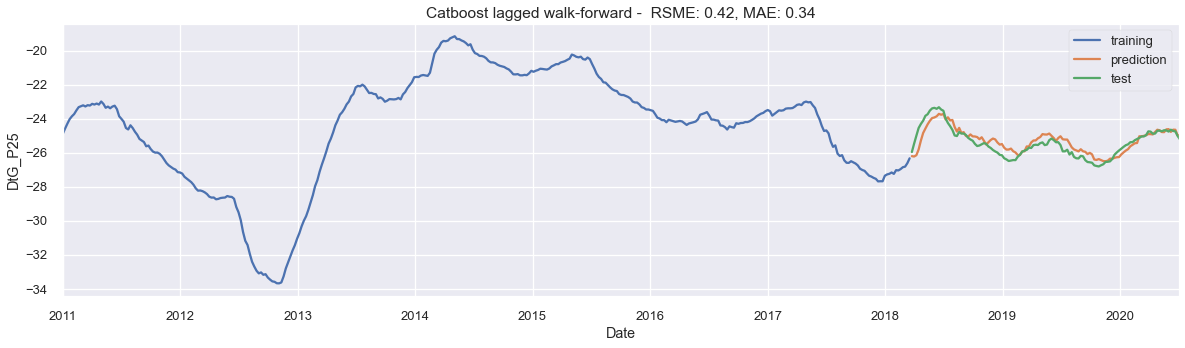

In [1092]:
boost_wlk_fwd = walkforward_Catboost(boost, X_train_lagged, y_train_lagged, X_test_lagged, y_test_lagged, 'W', prediction_window)

catboost_lag_wlk = plot_model_performance(y_train_lagged, boost_wlk_fwd, y_test_lagged, 'Catboost lagged walk-forward', '2011-01-01', '2020-07-01')
catboost_lag_wlk.savefig('./graphs/catboost_lag_wlk_only_features.jpg', bbox_inches='tight')

## LSTM

In [323]:
def preprocess_LSTM(data, look_back):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(data.shape[0]-look_back):
        x = data[i:look_back+i][::-1]
        y = data[look_back+i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_test = data[i+1:look_back+i+1][::-1]
    return X_train, y_train, input_seq_for_test


In [337]:
df_LSTM = df.copy()

df_LSTM['T_Pe'] = np.where(((df['T_Pe'] == 0) & (df['T_Pe'].shift(1) == 0)) | (df['T_Pe'].diff(-1) > 10) | ((df['T_Pe'] == 0) & (df['T_Pe'].shift(-1) == 0)), np.nan, df['T_Pe'])
df_LSTM['V_Pe'] = np.where(df['V_Pe'] == 0, np.nan, df['V_Pe'])
df_LSTM['H_FCP'] = np.where(df['H_FCP'] == 0, np.nan, df['H_FCP'])
df_LSTM['T_Pe'] = df['T_Pe'].fillna(df['T_BU'])

df_LSTM['V_Pe'] = df_LSTM['V_Pe'].interpolate()
df_LSTM['H_FCP'] = df_LSTM['H_FCP'].interpolate()
df_LSTM['DtG_P25'] = df_LSTM['DtG_P25'].interpolate()
df_LSTM['DtG_P24'] = df_LSTM['DtG_P24'].interpolate()


In [339]:
train_LSTM = df_LSTM[:-52*7]
test_LSTM = df_LSTM[-52*7:]